# Rossman Sales Prediction

## Import Module

In [1]:
import warnings
warnings.filterwarnings("ignore")

import math
import random
import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
import category_encoders as ce

import xgboost as xgb


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

import xgboost as xgb

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

import pickle

## Data Loading:

In [2]:
df_store = pd.read_csv("C:\\Users\\ADMIN\\Downloads\\Rossman\\store.csv", index_col = 0)
df_sales = pd.read_csv("C:\\Users\\ADMIN\\Downloads\\Rossman\\train.csv", index_col = 0)

Data Inspection:

Hai dataset bao gồm store.csv (chứa dữ liệu về store) và train.csv (chứa dữ liệu về sales). Hai dataset này cần được merge sau khi data cleaning.

### Store Dataset

In [3]:
df_store.shape

(1115, 9)

In [4]:
df_store.head()

,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Store,,,,,,,,,
1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1115 entries, 1 to 1115
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   StoreType                  1115 non-null   object 
 1   Assortment                 1115 non-null   object 
 2   CompetitionDistance        1112 non-null   float64
 3   CompetitionOpenSinceMonth  761 non-null    float64
 4   CompetitionOpenSinceYear   761 non-null    float64
 5   Promo2                     1115 non-null   int64  
 6   Promo2SinceWeek            571 non-null    float64
 7   Promo2SinceYear            571 non-null    float64
 8   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(1), object(3)
memory usage: 87.1+ KB


* Store datarame bao gồm 9 cột.
* Trong đó, có 6 cột chứa missing value

### Sales Dataset

In [6]:
df_store.shape

(1115, 9)

In [7]:
df_sales.head()

,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Store,,,,,,,,
1,5,2015-07-31,5263,555,1,1,0,1
2,5,2015-07-31,6064,625,1,1,0,1
3,5,2015-07-31,8314,821,1,1,0,1
4,5,2015-07-31,13995,1498,1,1,0,1
5,5,2015-07-31,4822,559,1,1,0,1


In [8]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1017209 entries, 1 to 1115
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   DayOfWeek      1017209 non-null  int64 
 1   Date           1017209 non-null  object
 2   Sales          1017209 non-null  int64 
 3   Customers      1017209 non-null  int64 
 4   Open           1017209 non-null  int64 
 5   Promo          1017209 non-null  int64 
 6   StateHoliday   1017209 non-null  object
 7   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 69.8+ MB


* Sales dataframe gồm 8 cột.
* Không có cột nào chứa missing value

## Data Cleaning:

### Handle Missing Values

Store dataframe có 5 cột chứa missing value, bao gồm các cột CompetitionDistance, CompetitionOpenSinceMonth, CompetitionOpenSinceYear, Promo2SinceYear, Promo2SinceWeek, PromoInterval

In [9]:
missing_count = df_store.isnull().sum()
missing_columns = missing_count[missing_count > 0]
missing_percentage = (missing_columns / len(df_store)) * 100
missing_percentage = missing_percentage.map('{:.2f}%'.format)
missing_percentage

CompetitionDistance           0.27%
CompetitionOpenSinceMonth    31.75%
CompetitionOpenSinceYear     31.75%
Promo2SinceWeek              48.79%
Promo2SinceYear              48.79%
PromoInterval                48.79%
dtype: object

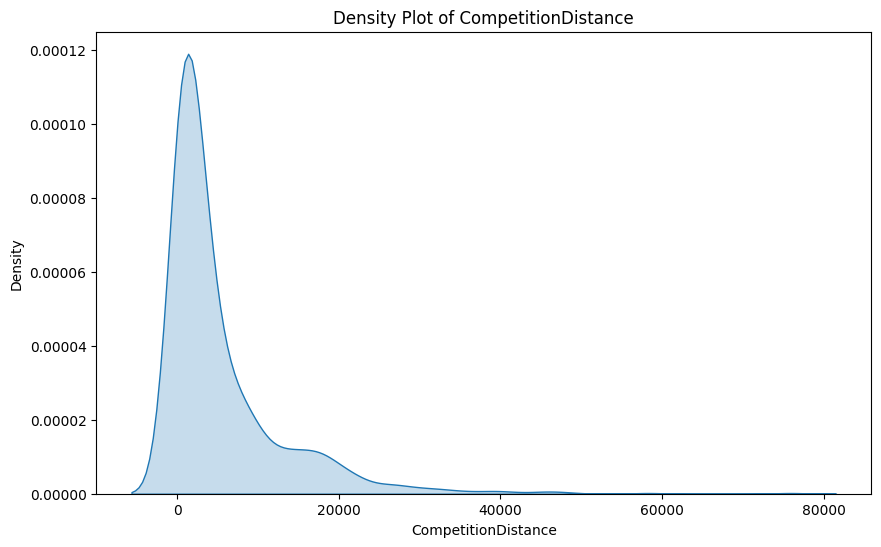

In [10]:
plt.figure(figsize=(10, 6)) 
sns.kdeplot(df_store['CompetitionDistance'], shade=True) 
plt.title('Density Plot of CompetitionDistance')  
plt.xlabel('CompetitionDistance') 
plt.ylabel('Density')
plt.show()

Do phân phối của CompetitionDistance có độ lệch dương (positively skewed) và CompetitionDistance là một numerical feature. Missing value sẽ được thay thế bởi median của CompetitionDistance.

In [11]:
df_store["CompetitionDistance"].fillna(value = df_store.CompetitionDistance.median(), inplace=True)

CompetitionOpenSinceMonth và CompetitionOpenSinceYear có số lượng missing value. Có thể các missing value ở những cột này ở các dòng giống nhau. Điều này sẽ được kiểm tra  Missing value ở hai cột này sẽ được thay thế bằng giá trị xuất hiện thường xuyên nhất ở mỗi cột

In [12]:
missing_both = df_store[df_store['CompetitionOpenSinceMonth'].isnull() & df_store['CompetitionOpenSinceYear'].isnull()]
num_missing_both = missing_both.shape[0]


Số dòng có xuất hiện missing value ở hai cột trên bằng số dòng xuất hiện missing value ở mỗi cột. Nghi ngờ được đặt ra là đúng, tiếp theo kiểm tra các dòng này liệu có liên quan đến cột CompetitionDistance hay không.

In [13]:
df_store[np.isnan(df_store["CompetitionOpenSinceMonth"])].loc[:, ["CompetitionDistance", "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"]]

,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear
Store,,,
12,1070.0,NaN,NaN
13,310.0,NaN,NaN
16,3270.0,NaN,NaN
19,3240.0,NaN,NaN
22,1040.0,NaN,NaN
...,...,...,...
1096,1130.0,NaN,NaN
1100,540.0,NaN,NaN
1113,9260.0,NaN,NaN


Tại các dòng chứa missing value ở hai cột CompetitionOpenSinceMonth và CompetitionOpenSinceYear không có thông tin quy luật liên quan đến Competition Distance. Missing value ở hai cột này sẽ được thay thế bằng giá trị xuất hiện thường xuyên nhất ở mỗi cột

In [14]:
df_store["CompetitionOpenSinceMonth"].fillna(value = df_store.CompetitionOpenSinceMonth.mode()[0], inplace=True)
df_store["CompetitionOpenSinceYear"].fillna(value = df_store.CompetitionOpenSinceYear.mode()[0], inplace=True)

Promo2SinceWeek, Promo2SinceYear và PromoInterval có cùng số lượng missing value, do đó chúng có thể ở những dòng giống nhau. Điều này sẽ được kiểm tra.

In [15]:
missing_both = df_store[df_store['Promo2SinceWeek'].isnull() & df_store['Promo2SinceYear'].isnull() & df_store['PromoInterval'].isnull()]
num_missing_both = missing_both.shape[0]


Số dòng có xuất hiện missing value ở ba cột trên bằng số dòng xuất hiện missing value ở mỗi cột. Nghi ngờ được đặt ra là đúng, tiếp theo kiểm tra các dòng này liệu có liên quan đến cột Promo2 hay không.

In [16]:
df_store[np.isnan(df_store["Promo2SinceWeek"])].loc[:, ["Promo2", "Promo2SinceWeek", "Promo2SinceYear", "PromoInterval"]]


,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Store,,,,
1,0,NaN,NaN,NaN
4,0,NaN,NaN,NaN
5,0,NaN,NaN,NaN
6,0,NaN,NaN,NaN
7,0,NaN,NaN,NaN
...,...,...,...,...
1108,0,NaN,NaN,NaN
1110,0,NaN,NaN,NaN
1112,0,NaN,NaN,NaN


Ở head và tail của dataframe trên, Promo2 đều có giá trị bằng 0. Ta sẽ kiểm tra có phải tất cả các dòng của dataframe trên, tại cột Promo2 đều có giá trị bằng 0 hay không

In [17]:
filtered_df = df_store[np.isnan(df_store["Promo2SinceWeek"])]
num_promo2_zero = filtered_df[filtered_df["Promo2"] == 0].shape[0]
total_rows = filtered_df.shape[0]
percentage = (num_promo2_zero / total_rows) * 100 if total_rows > 0 else 0
print(f'Phần trăm số dòng có giá trị Promo2 bằng 0 trong các dòng có Promo2SinceWeek là NaN: {percentage}%')

Phần trăm số dòng có giá trị Promo2 bằng 0 trong các dòng có Promo2SinceWeek là NaN: 100.0%


Như vậy, các missing value xuất hiện trong 3 cột Promo2SinceWeek, Promo2SinceYear và PromoInterval đều do giá trị của các dòng tương ứng của cột Promo2 bằng 0. Vì vậy các missing value này sẽ được thay thế bằng 0.

In [18]:
df_store["Promo2SinceWeek"].fillna(value = 0, inplace=True)
df_store["Promo2SinceYear"].fillna(value = 0, inplace=True)
df_store["PromoInterval"].fillna(value = 0, inplace=True)

In [19]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1115 entries, 1 to 1115
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   StoreType                  1115 non-null   object 
 1   Assortment                 1115 non-null   object 
 2   CompetitionDistance        1115 non-null   float64
 3   CompetitionOpenSinceMonth  1115 non-null   float64
 4   CompetitionOpenSinceYear   1115 non-null   float64
 5   Promo2                     1115 non-null   int64  
 6   Promo2SinceWeek            1115 non-null   float64
 7   Promo2SinceYear            1115 non-null   float64
 8   PromoInterval              1115 non-null   object 
dtypes: float64(5), int64(1), object(3)
memory usage: 87.1+ KB


Không còn missing value trong dataframe df_store

### Merging Dataframes

In [20]:
#df_rossmann = df_sales.merge(right=df_store, on="Store", how="left").reset_index()
df_rossmann = pd.read_csv("merged.csv")

In [21]:
df_rossmann.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


### Conversion of Column Datatype

Kiểm tra datatype các cột của dataframe sau khi merge

In [22]:
df_rossmann.dtypes

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [23]:
#Chuyển kiểu của cột date sang kiểu datetime
df_rossmann['Date'] = pd.to_datetime(df_rossmann['Date'])

In [24]:
df_rossmann["StateHoliday"].unique()

array([0, '0', 'a', 'b', 'c'], dtype=object)

In [25]:
#Chuyển kiểu của cột StateHoliday sang kiểu int
df_rossmann["StateHoliday"].replace({'0':0, 'a':1, 'b':1, 'c':1}, inplace=True)


In [26]:
#Chuyển kiểu của các cột CompetitionOpenSinceMonth, CompetitionOpenSinceYear, Promo2SinceWeek và Promo2SinceYear sang kiểu int
df_rossmann = df_rossmann.astype({"CompetitionOpenSinceMonth":int, "CompetitionOpenSinceYear":int, "Promo2SinceWeek":int, "Promo2SinceYear":int})


In [27]:
df_rossmann.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                          int64
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth             int32
CompetitionOpenSinceYear              int32
Promo2                                int64
Promo2SinceWeek                       int32
Promo2SinceYear                       int32
PromoInterval                        object
dtype: object

### Extract Date Column

In [28]:
get_week_number = lambda x: x.isocalendar()[1]
df_rossmann['WeekOfYear'] = df_rossmann['Date'].apply(get_week_number)
df_rossmann['Month'] = df_rossmann['Date'].dt.month
df_rossmann['Year'] = df_rossmann['Date'].dt.year

### Create new feature

In [29]:
#Cột CompetitionOpenNumMonths thể hiện số tháng kể từ lức cửa hàng cạnh tranh mở cửa
df_rossmann['CompetitionOpenNumMonths'] = (df_rossmann['Year'] - df_rossmann['CompetitionOpenSinceYear']) * 12 + (df_rossmann['Month'] - df_rossmann['CompetitionOpenSinceMonth'])
#Cột Promo2NumWeeks thể hiện số tuần mà chương trình khuyến mãi (Promo2) bắt đầu
df_rossmann['Promo2NumWeeks'] = (df_rossmann['Year'] - df_rossmann['Promo2SinceYear']) * 52 + (df_rossmann['WeekOfYear'] - df_rossmann['Promo2SinceWeek'])


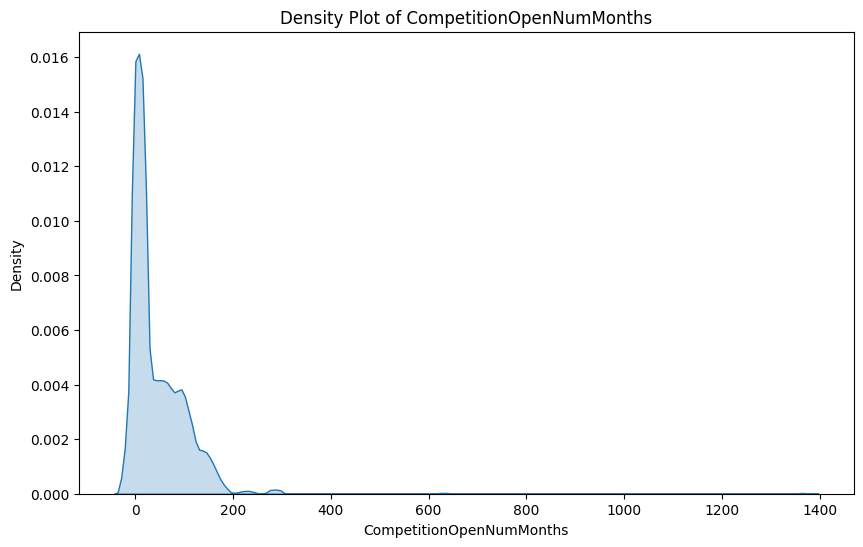

In [30]:
#Kiểm tra phân phối cột mới (CompetitionOpenNumMonths)
plt.figure(figsize=(10, 6)) 
sns.kdeplot(df_rossmann['CompetitionOpenNumMonths'], shade=True) 
plt.title('Density Plot of CompetitionOpenNumMonths')  
plt.xlabel('CompetitionOpenNumMonths') 
plt.ylabel('Density')
plt.show()


Xuất hiện các giá trị âm tại cột mới CompetitionOpenNumMonths. Tiến hành kiểm tra nguyên nhân của các giá trị âm

In [31]:
df_rossmann[df_rossmann['CompetitionOpenNumMonths'] < 0].loc[:, ['Year', 'Month', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']]

,Year,Month,CompetitionOpenSinceYear,CompetitionOpenSinceMonth
687,2015,7,2015,8
1019,2015,7,2015,8
1071,2015,7,2015,8
1802,2015,7,2015,8
2134,2015,7,2015,8
...,...,...,...,...
1017193,2013,1,2013,9
1017204,2013,1,2014,6
1017206,2013,1,2013,9
1017207,2013,1,2013,9


Nguyên nhân của một số giá trị âm của cột CompetitionOpenNumMonths do một số cửa hàng đối thử chưa mở khi dữ liệu doanh số bán hàng được ghi. Chuyển các giá trị âm tại cột này thành 0. 

In [32]:
df_rossmann['CompetitionOpenNumMonths'] = df_rossmann['CompetitionOpenNumMonths'].apply(lambda x: 0 if x < 0 else x)

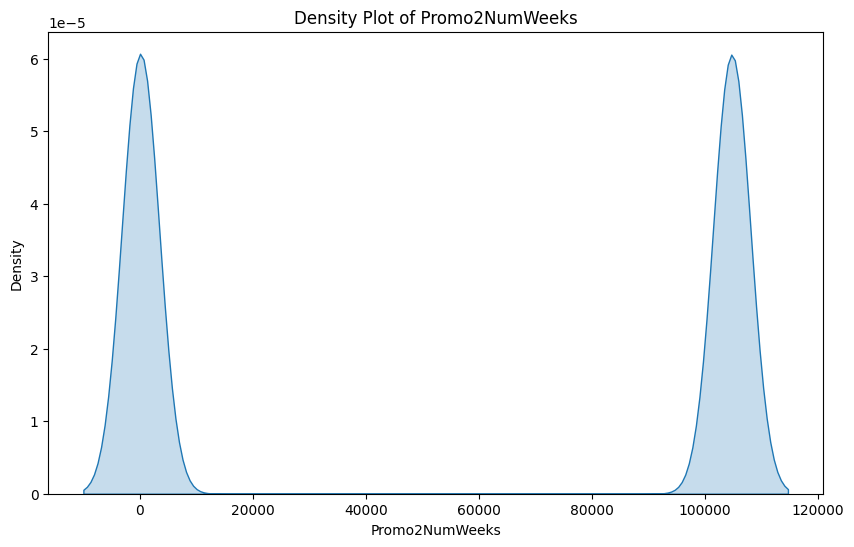

In [33]:
#Kiểm tra phân phối cột mới (Promo2NumWeeks).
plt.figure(figsize=(10, 6)) 
sns.kdeplot(df_rossmann['Promo2NumWeeks'], shade=True) 
plt.title('Density Plot of Promo2NumWeeks')  
plt.xlabel('Promo2NumWeeks') 
plt.ylabel('Density')
plt.show()

Xuất hiện cả các giá trị âm và các giá trị quá lớn bất thường tại cột mới Promo2NumWeeks. Tiến hành kiểm tra nguyên nhân của các giá trị quá lớn bất thường này.

In [34]:
df_rossmann[df_rossmann['Promo2NumWeeks'] > 90000].loc[:, ['WeekOfYear', 'Year', 'Promo2SinceWeek', 'Promo2SinceYear', 'Promo2NumWeeks', 'Promo2']]

,WeekOfYear,Year,Promo2SinceWeek,Promo2SinceYear,Promo2NumWeeks,Promo2
0,31,2015,0,0,104811,0
3,31,2015,0,0,104811,0
4,31,2015,0,0,104811,0
5,31,2015,0,0,104811,0
6,31,2015,0,0,104811,0
...,...,...,...,...,...,...
1017201,1,2013,0,0,104677,0
1017203,1,2013,0,0,104677,0
1017205,1,2013,0,0,104677,0
1017206,1,2013,0,0,104677,0


Các giá trị lớn bất thường tại cột Promo2NumWeeks do tại các dòng này giá trị Promo2SinceYear và Promo2SinceWeek bằng 0, tại giá trị Promo2 bằng 0. Chuyển các giá trị lớn bất thường này về 0.

In [35]:
#Tại các dòng có giá trị Promo2  bằng 0, chuyển giá trị Promo2NumWeeks bằng 0
df_rossmann.loc[df_rossmann['Promo2'] == 0, 'Promo2NumWeeks'] = 0

Kiểm tra nguyên nhân giá trị âm xuất hiện tại cột mới Promo2NumWeeks

In [36]:
df_rossmann[df_rossmann['Promo2NumWeeks'] < 0].loc[:, ['WeekOfYear', 'Year', 'Promo2SinceWeek', 'Promo2SinceYear', 'Promo2NumWeeks']]

,WeekOfYear,Year,Promo2SinceWeek,Promo2SinceYear,Promo2NumWeeks
68442,22,2015,23,2015,-1
68643,22,2015,23,2015,-1
68886,22,2015,23,2015,-1
69557,22,2015,23,2015,-1
69758,22,2015,23,2015,-1
...,...,...,...,...,...
1017195,1,2013,40,2014,-91
1017196,1,2013,5,2013,-4
1017198,1,2013,5,2013,-4
1017199,1,2013,31,2013,-30


Nguyên nhân các giá trị âm xuất hiện do chương trình khuyến mãi chưa đưỡ bắt đầu khi dữ liệu về doanh số được ghi nhận. Chuyển các giá trị âm này về 0.

In [37]:
df_rossmann['Promo2NumWeeks'] = df_rossmann['Promo2NumWeeks'].apply(lambda x: 0 if x < 0 else x)

### Detect Outlier

#### Sales

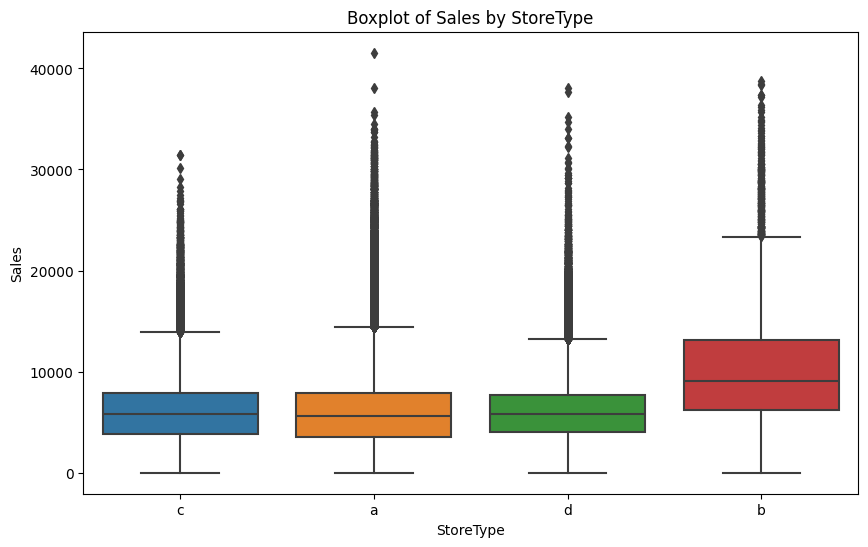

In [38]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='StoreType', y='Sales', data=df_rossmann)
plt.title('Boxplot of Sales by StoreType')
plt.show()

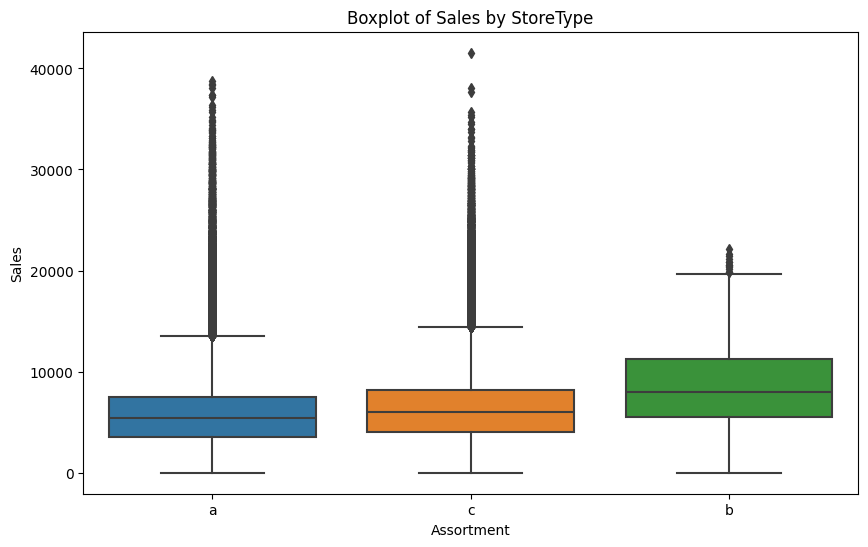

In [39]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Assortment', y='Sales', data=df_rossmann)
plt.title('Boxplot of Sales by StoreType')
plt.show()

Do mỗi StoreType có khoảng Sales khác nhau, các outlier sẽ được xác định riêng theo từng StoreType. Tương tự, mỗi Assortment có khoảng Sales khác nhau, các outlier sẽ được xác định riêng theo từng Assortment

In [40]:
def remove_outliers_by_group(df, group_column, target_column):
    """
    Loại bỏ outliers cho target_column dựa trên giá trị của group_column.
    
    Parameters:
    - df: DataFrame chứa dữ liệu.
    - group_column: Tên cột dùng để nhóm dữ liệu ('StoreType', 'Assortment', v.v.).
    - target_column: Tên cột cần loại bỏ outliers ('Sales', 'Customer', v.v.).
    
    Returns:
    - DataFrame sau khi đã loại bỏ outliers.
    """
    # Lặp qua mỗi giá trị unique trong nhóm cột
    for group_value in df[group_column].unique():
        # Tính Q1 và Q3 cho target_column
        Q1 = df[df[group_column] == group_value][target_column].quantile(0.25)
        Q3 = df[df[group_column] == group_value][target_column].quantile(0.75)
        IQR = Q3 - Q1

        # Tính giới hạn dưới và giới hạn trên
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Loại bỏ outliers
        df = df[~((df[group_column] == group_value) & ((df[target_column] < lower_bound) | (df[target_column] > upper_bound)))]

    return df


In [41]:
df_rossmann = remove_outliers_by_group(df_rossmann, 'StoreType', 'Sales')

df_rossmann = remove_outliers_by_group(df_rossmann, 'Assortment', 'Sales')

#### Customer

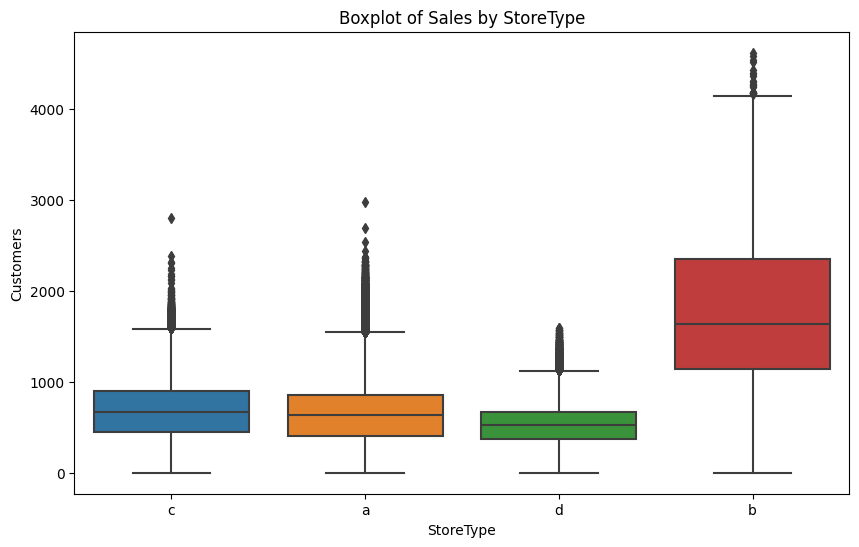

In [42]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='StoreType', y='Customers', data=df_rossmann)
plt.title('Boxplot of Sales by StoreType')
plt.show()

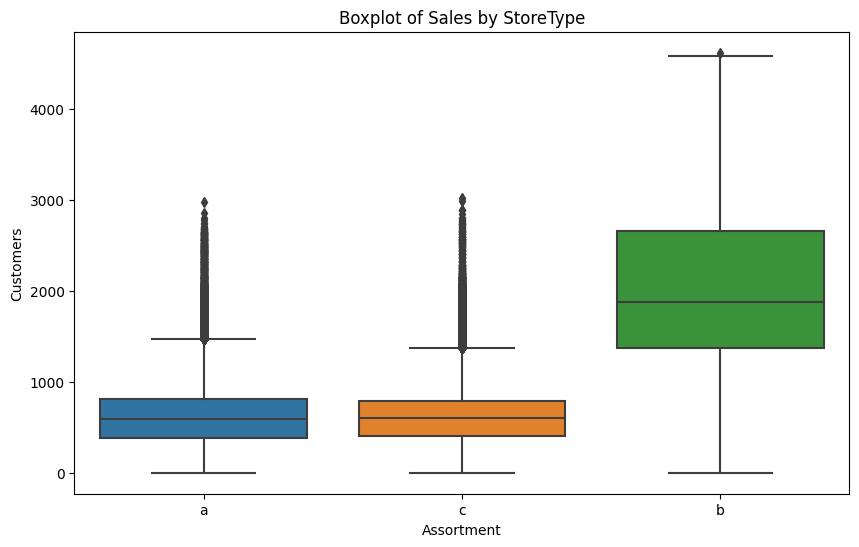

In [43]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Assortment', y='Customers', data=df_rossmann)
plt.title('Boxplot of Sales by StoreType')
plt.show()

In [44]:
df_rossmann = remove_outliers_by_group(df_rossmann, 'StoreType', 'Customers')

df_rossmann = remove_outliers_by_group(df_rossmann, 'Assortment', 'Customers')

#### Competition Distance


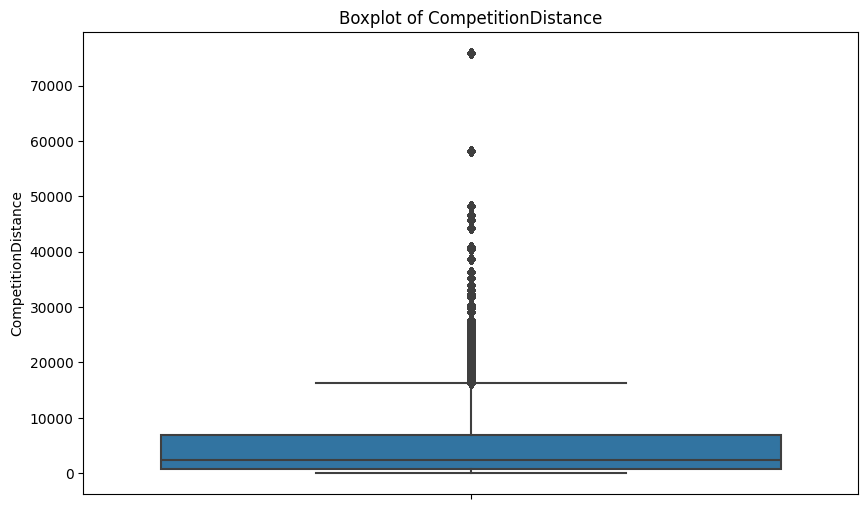

In [45]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='CompetitionDistance', data=df_rossmann)
plt.title('Boxplot of CompetitionDistance')
plt.show()

In [46]:
Q1 = df_rossmann['CompetitionDistance'].quantile(0.25)
Q3 = df_rossmann['CompetitionDistance'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


rossmann_df_no_outliers = df_rossmann[(df_rossmann['CompetitionDistance'] >= lower_bound) & 
                                      (df_rossmann['CompetitionDistance'] <= upper_bound)]

## Exploratory Data Analysis

In [47]:
df_eda_rossman = df_rossmann.copy()

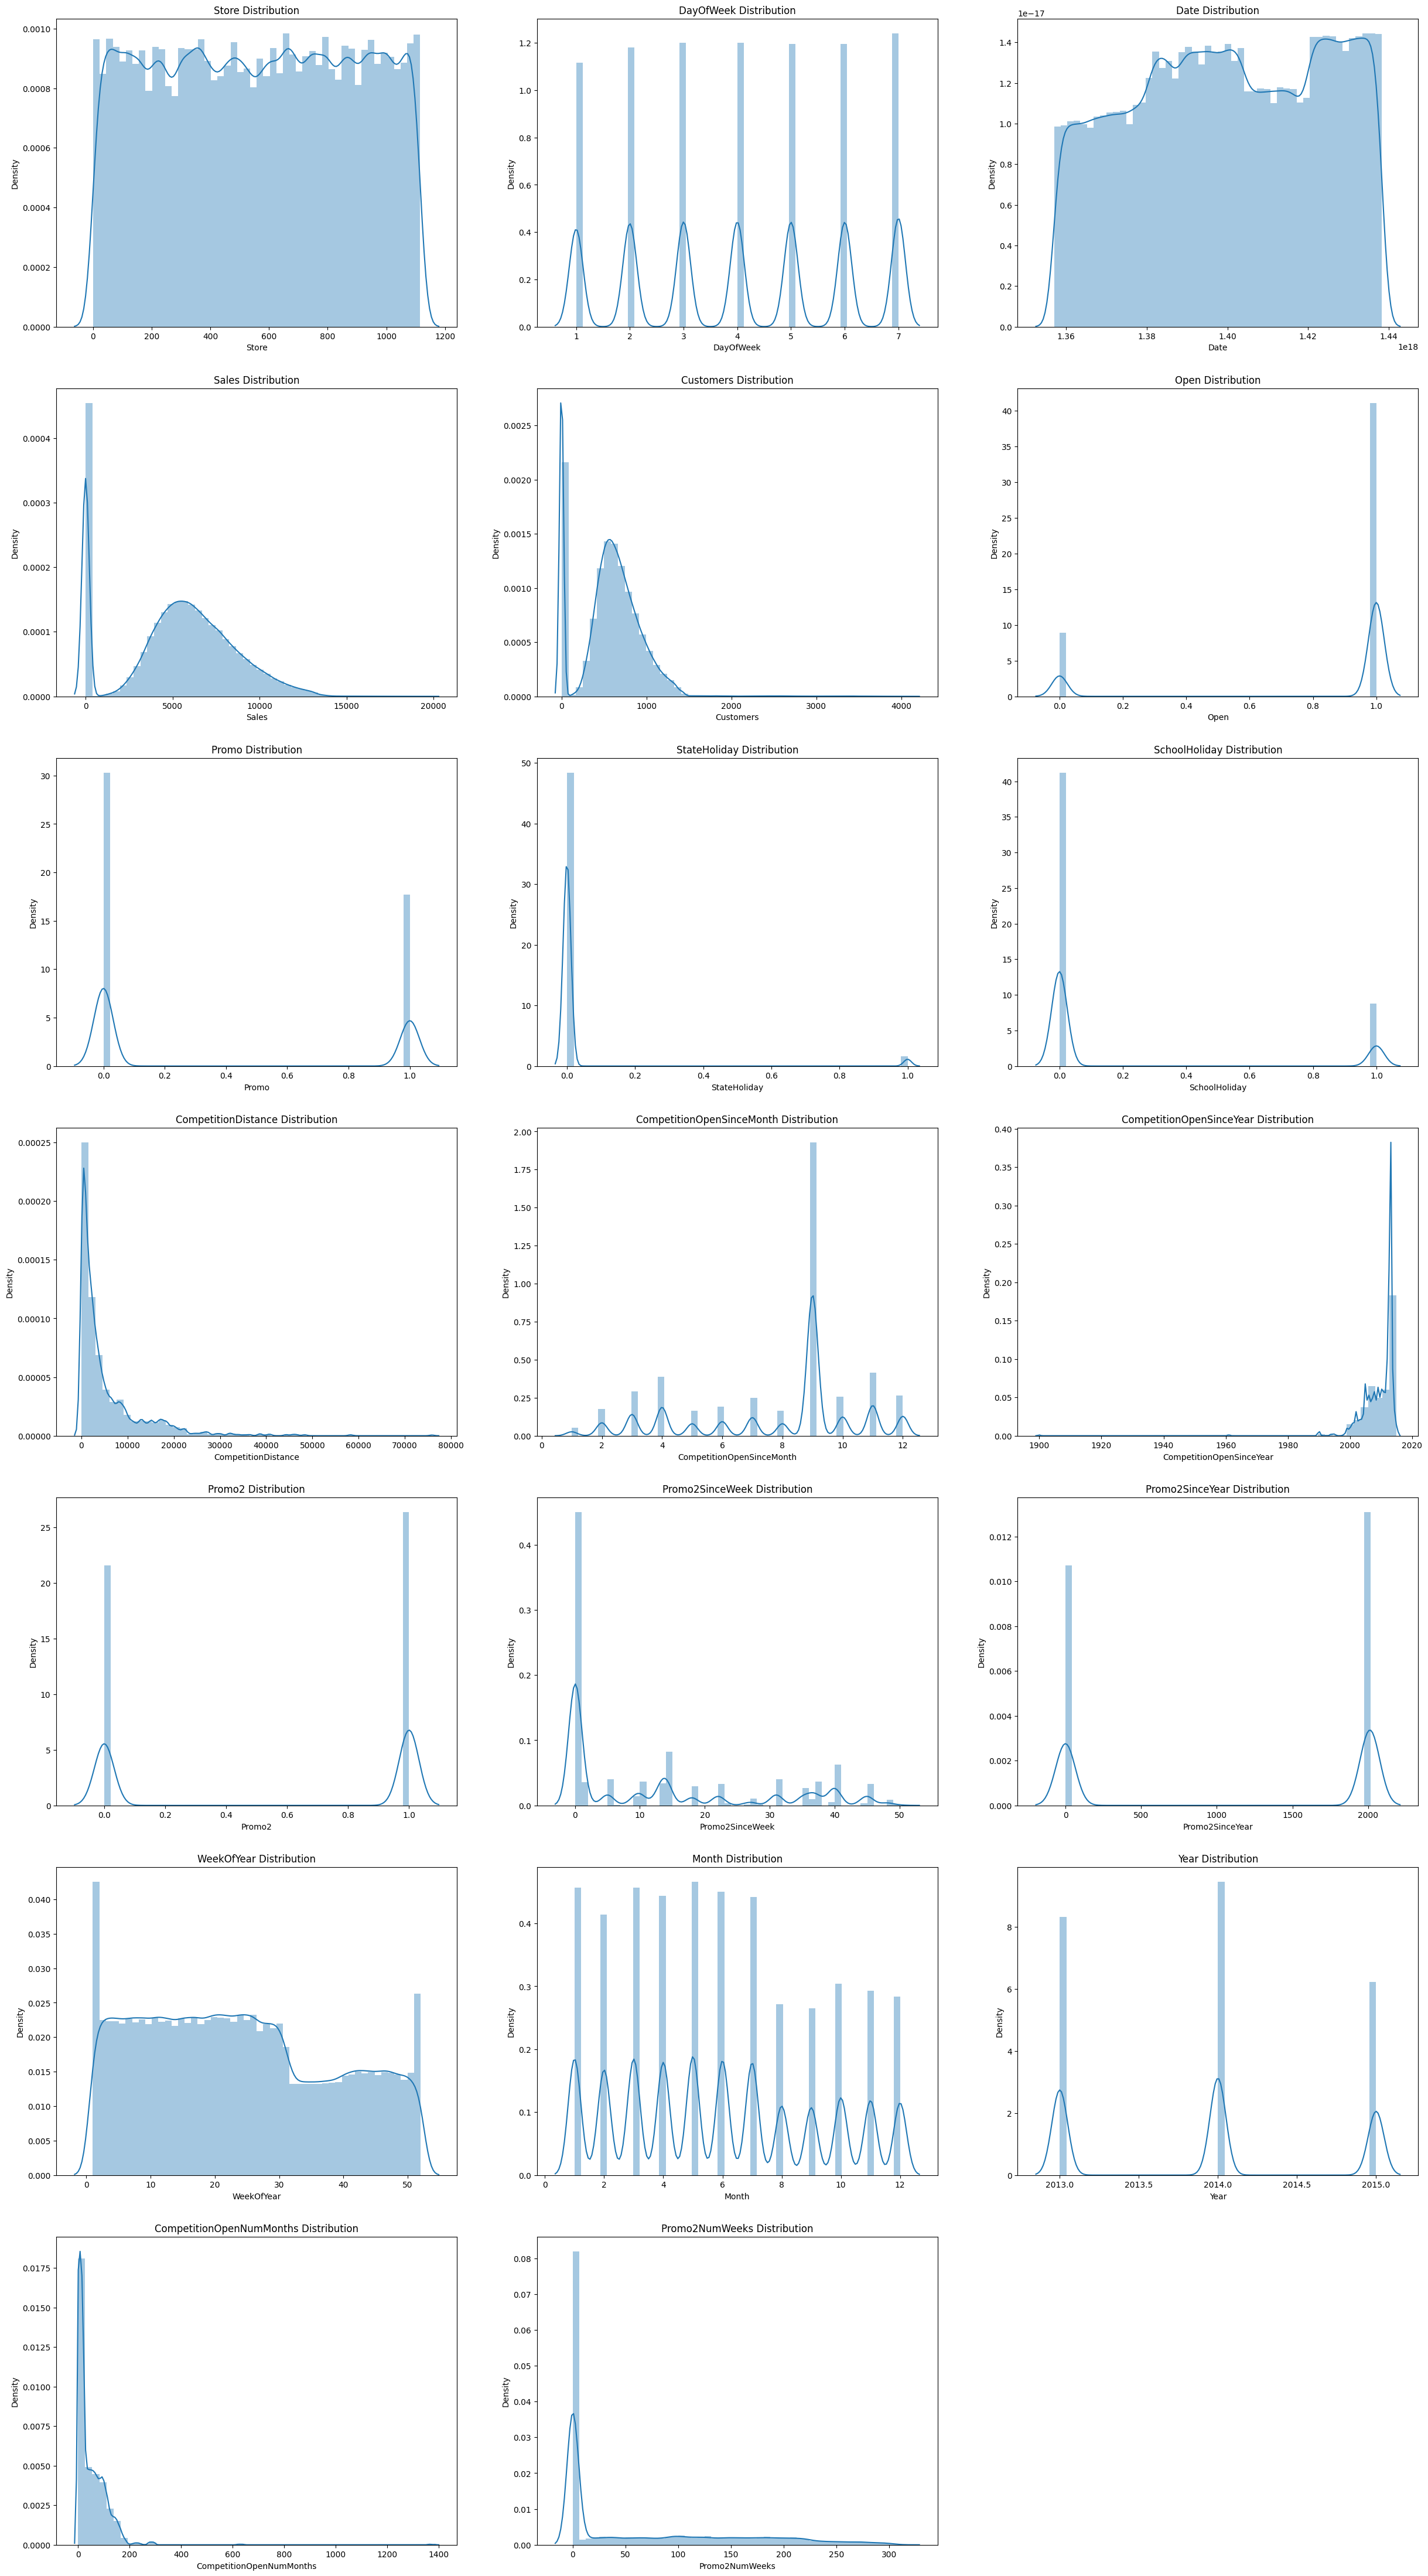

In [48]:
def density_plot_of_all_features(dataframe):
  columns = dataframe.describe().columns.tolist()

  columns_num = 3
  rows_num = math.ceil(len(columns)/columns_num)
  fig, axes = plt.subplots(rows_num, columns_num, figsize=(10*columns_num, 8*rows_num))

  row = -1
  column = columns_num - 1
  for feature in columns:
    if column == (columns_num - 1):
      row += 1
      column = 0
    else:
      column += 1
    sns.distplot(ax=axes[row, column], a=dataframe[feature])
    axes[row, column].set_title(f"{feature} Distribution")
  
  if len(columns) % columns_num != 0:
    for column_num in range(column + 1, columns_num):
      fig.delaxes(axes[rows_num - 1][column_num])
            
density_plot_of_all_features(df_eda_rossman[(df_eda_rossman['CompetitionOpenNumMonths'] != 0) | (df_eda_rossman['Promo2NumWeeks'] != 0)])

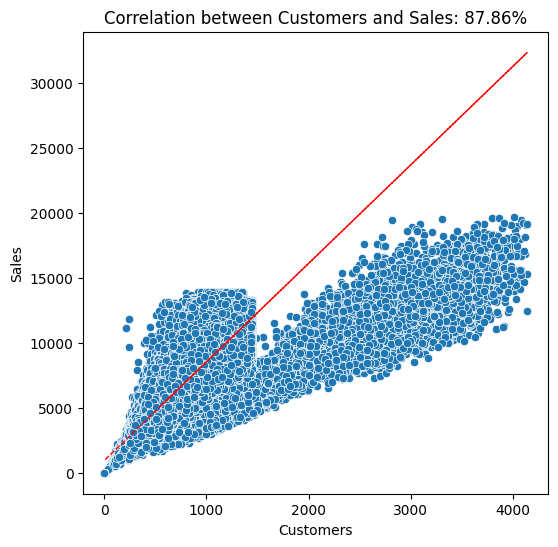

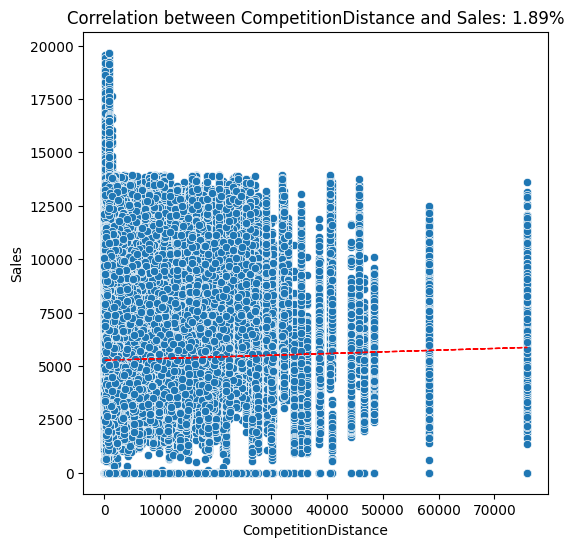

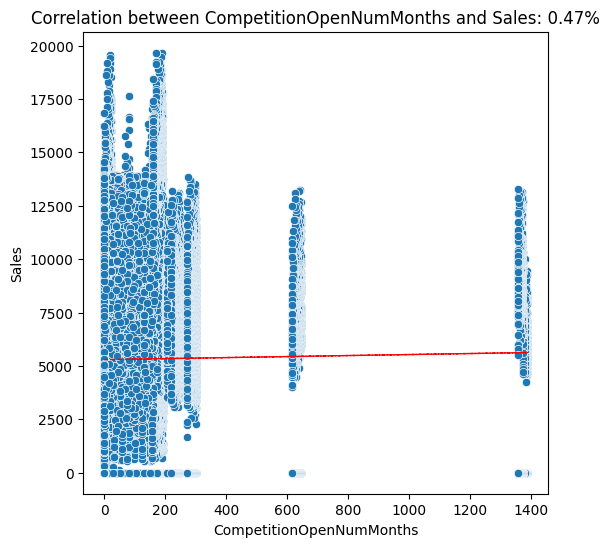

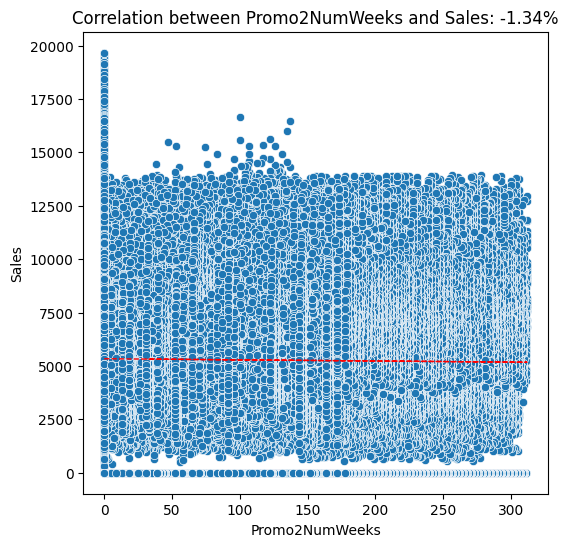

In [49]:
def scatter_plot_with_regression_line(dataframe, x_feature, y_feature):
  plt.figure(figsize=(6,6))
  sns.scatterplot(x=x_feature, y=y_feature, data=dataframe)

  lin_fit = np.polyfit(dataframe[x_feature], dataframe[y_feature], 1)
  lin_func = np.poly1d(lin_fit)(dataframe[x_feature])
  plt.plot(dataframe[x_feature], lin_func, "r--", lw=1)

  plt.title(f"Correlation between {x_feature} and {y_feature}: {round(dataframe[x_feature].corr(dataframe[y_feature])*100, 2)}%")
# generate scatter plot to show the variation in sales with the numerical features
numerical_features = ['Customers', 'CompetitionDistance', 'CompetitionOpenNumMonths', 'Promo2NumWeeks']

for feature in numerical_features:
  scatter_plot_with_regression_line(df_eda_rossman, feature, 'Sales')

Mối quan hệ giữa doanh số và số lượng khách hàng gần như là tuyến tính. Vì vậy, chúng ta có thể an tâm rằng khi số lượng khách hàng tăng lên, doanh số cũng tăng lên.

Doanh số giảm đi khi khoảng cách đến đối thủ cạnh tranh, số tháng mở của đối thủ cạnh tranh và số tuần khuyến mãi 2 (promo2) tăng lên nhưng chúng lại có mối tương quan rất thấp (≈0).

In [50]:
print(df_rossmann.head())

   Store  DayOfWeek       Date  Sales  Customers  Open  Promo  StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1             0   
1      2          5 2015-07-31   6064        625     1      1             0   
2      3          5 2015-07-31   8314        821     1      1             0   
4      5          5 2015-07-31   4822        559     1      1             0   
5      6          5 2015-07-31   5651        589     1      1             0   

   SchoolHoliday StoreType  ... CompetitionOpenSinceYear  Promo2  \
0              1         c  ...                     2008       0   
1              1         a  ...                     2007       1   
2              1         a  ...                     2006       1   
4              1         a  ...                     2015       0   
5              1         a  ...                     2013       0   

   Promo2SinceWeek  Promo2SinceYear    PromoInterval  WeekOfYear  Month  Year  \
0                0                0

In [51]:
print(df_eda_rossman.head(10))

    Store  DayOfWeek       Date  Sales  Customers  Open  Promo  StateHoliday  \
0       1          5 2015-07-31   5263        555     1      1             0   
1       2          5 2015-07-31   6064        625     1      1             0   
2       3          5 2015-07-31   8314        821     1      1             0   
4       5          5 2015-07-31   4822        559     1      1             0   
5       6          5 2015-07-31   5651        589     1      1             0   
7       8          5 2015-07-31   8492        833     1      1             0   
8       9          5 2015-07-31   8565        687     1      1             0   
9      10          5 2015-07-31   7185        681     1      1             0   
10     11          5 2015-07-31  10457       1236     1      1             0   
11     12          5 2015-07-31   8959        962     1      1             0   

    SchoolHoliday StoreType  ... CompetitionOpenSinceYear  Promo2  \
0               1         c  ...                  

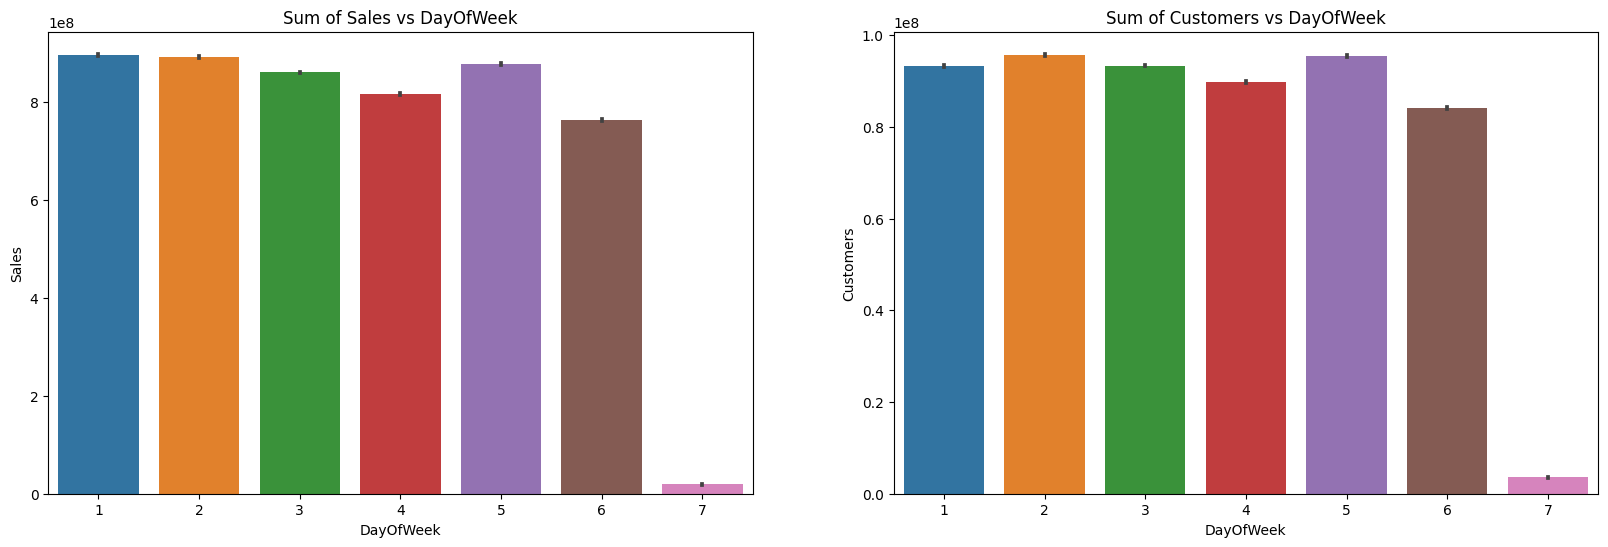

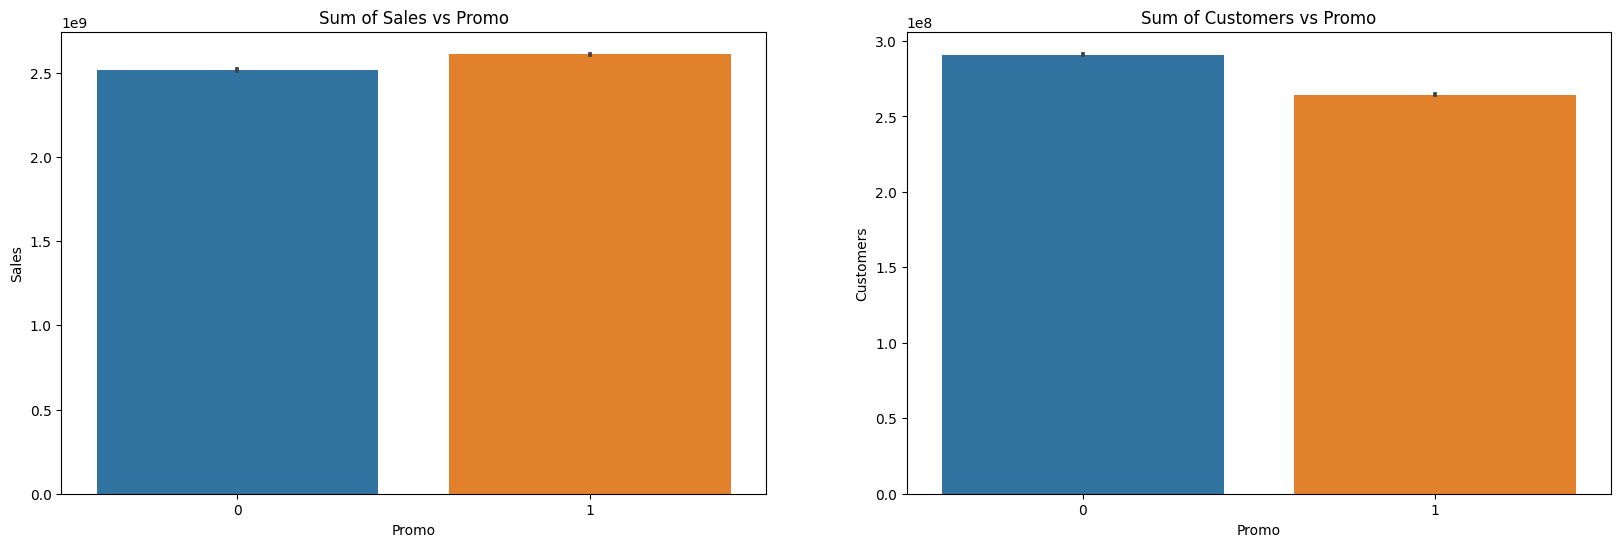

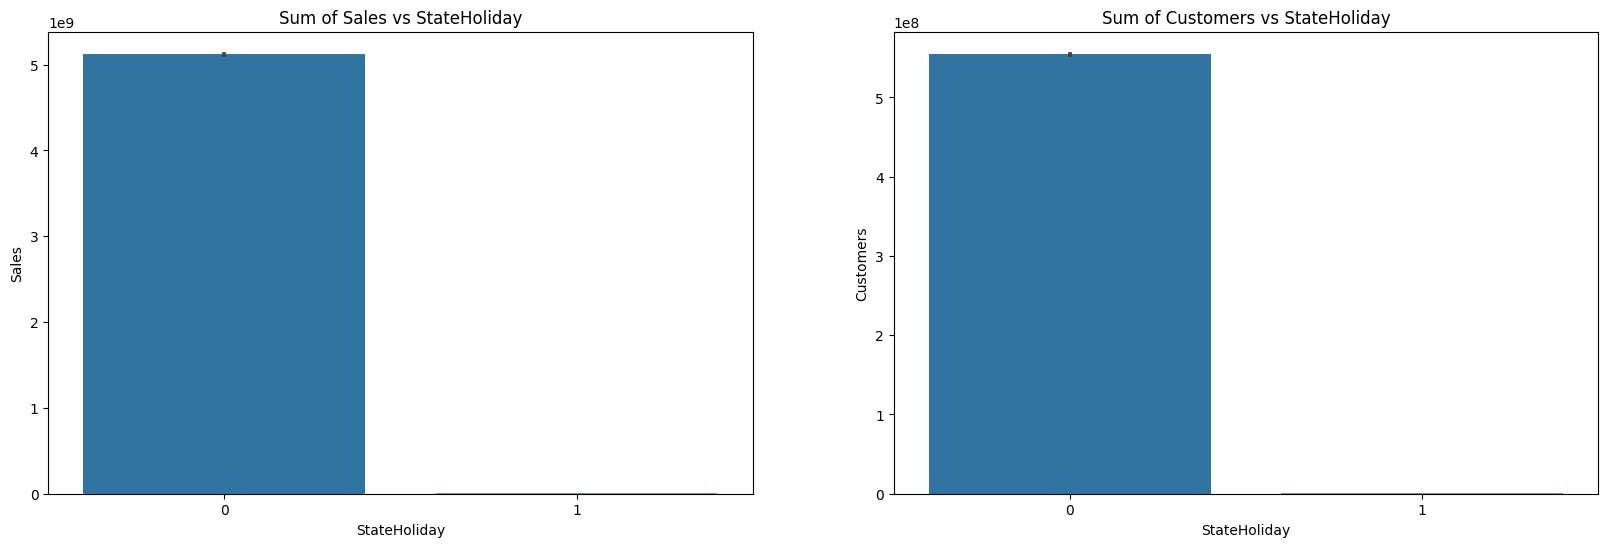

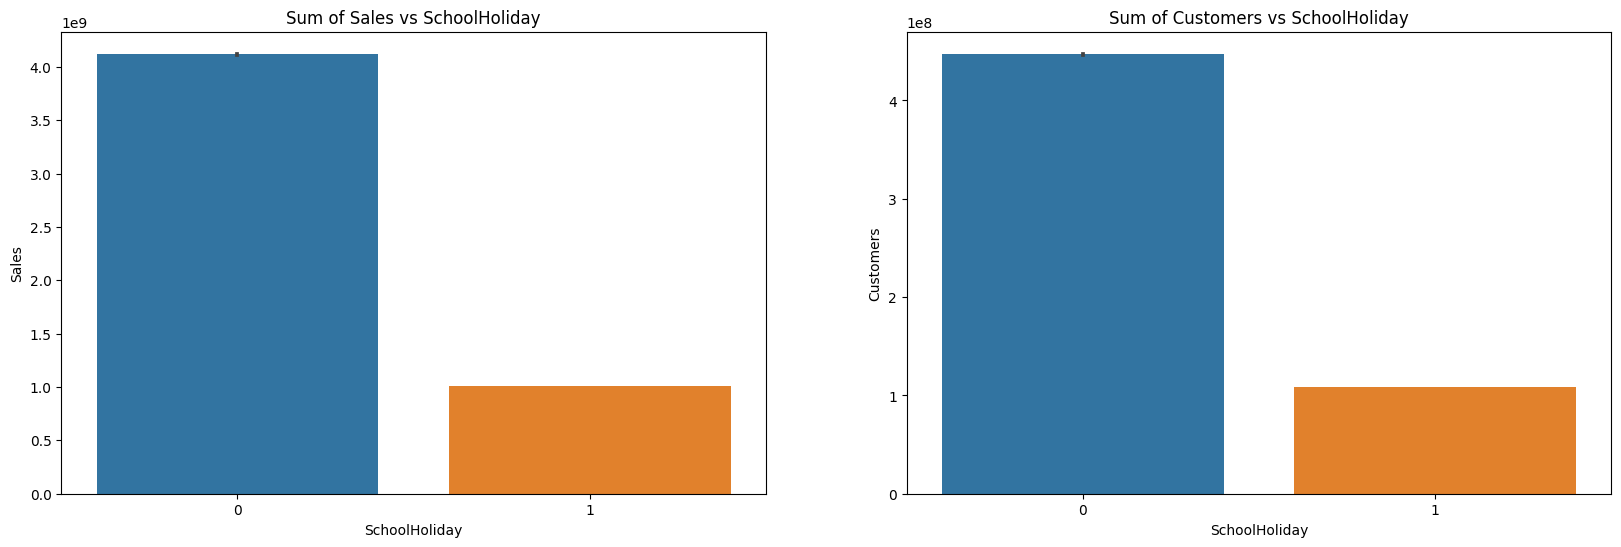

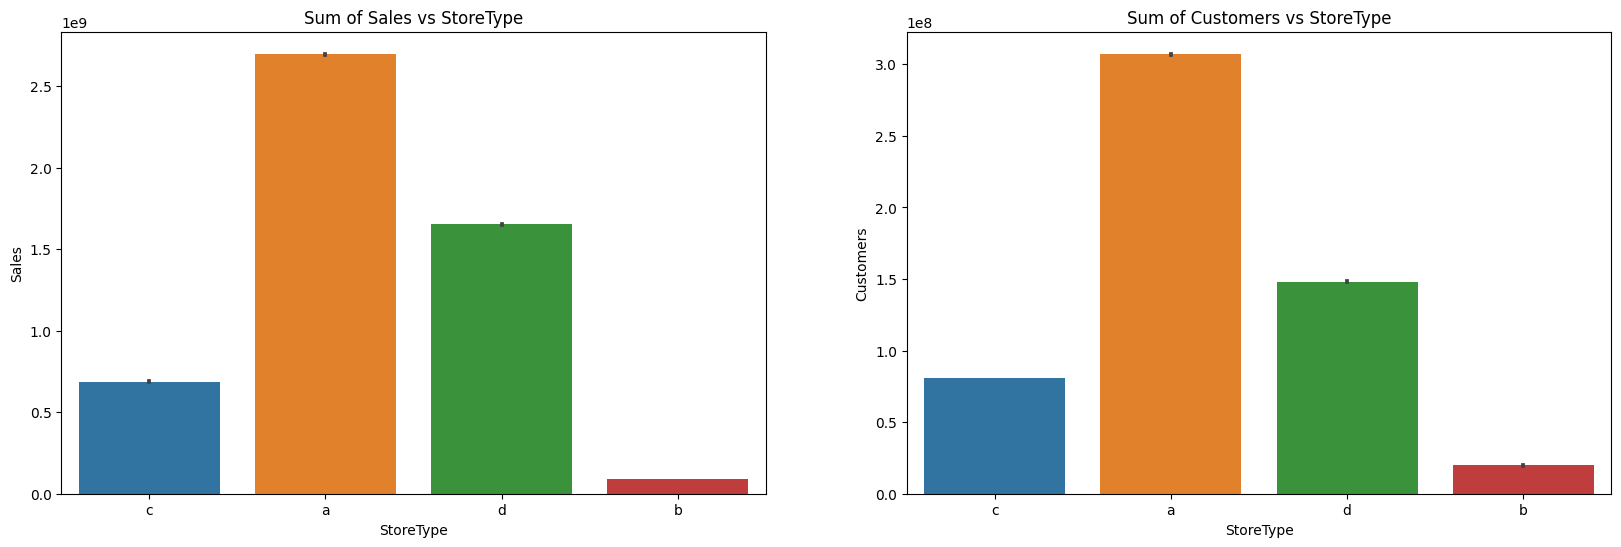

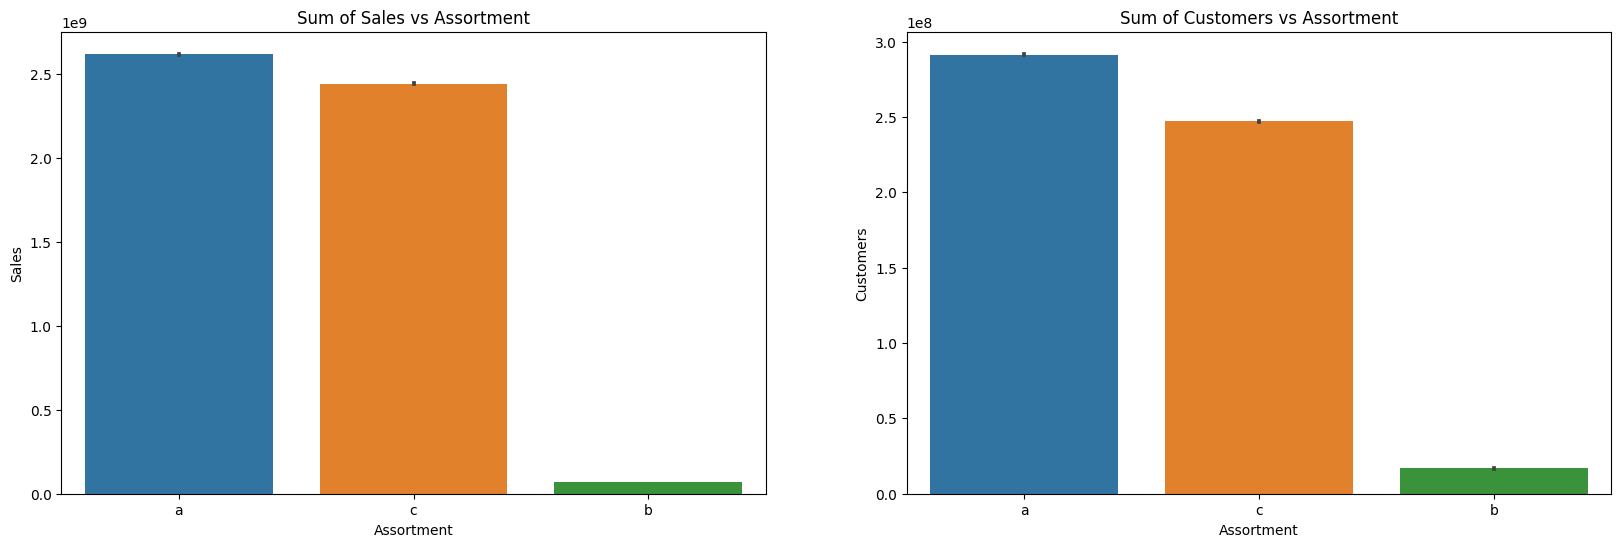

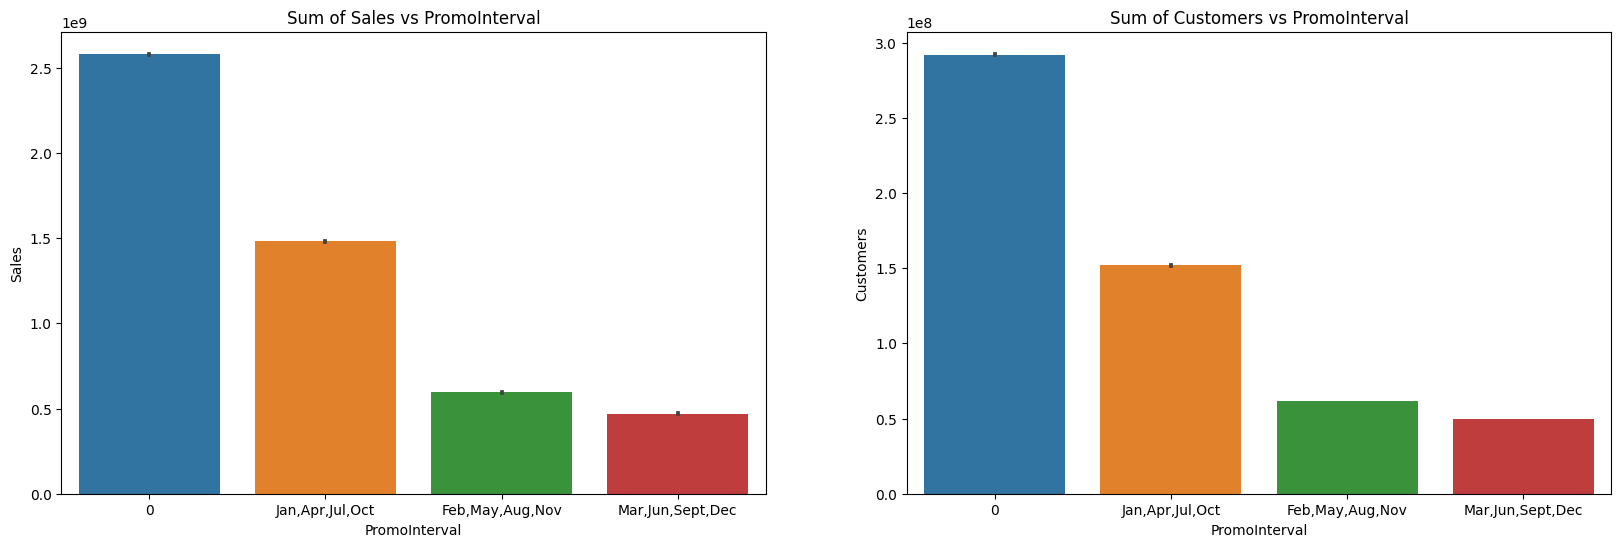

In [52]:
# define a function to plot bar graph with two features
# prints a bar graph
def plot_bar_graph_with_two_features(dataframe, x_feature, y_feature):
  if type(y_feature) == list:
    size = len(y_feature)
    fig, axes = plt.subplots(1, size, figsize=(10*size, 6))
    column = -1
    for feature in y_feature:
      column += 1
      sns.barplot(ax=axes[column], x=dataframe[x_feature], y=dataframe[feature], estimator=sum)
      axes[column].set_title(f"Sum of {feature} vs {x_feature}")
  else:
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=dataframe[x_feature], y=dataframe[y_feature], estimator=sum)
    ax.set_title(f"Sum of {y_feature} vs {x_feature}")
    plt.show()
# categotical variables under consideration
categorical_variables = ['DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                         'StoreType', 'Assortment', 'PromoInterval']

# plot bar graphs for each categorical variable against the sum of sales
for feature in categorical_variables:
  plot_bar_graph_with_two_features(df_eda_rossman, feature, ['Sales', 'Customers'])

- Doanh số cao nhất được ghi nhận vào các ngày thứ hai và doanh số thấp nhất được ghi nhận vào các ngày chủ nhật. Điều này có thể là do hầu hết các cửa hàng đều đóng cửa vào chủ nhật và điều này dẫn đến nhu cầu cao hơn vào ngày tiếp theo, đó là thứ hai.
- Các chương trình khuyến mãi làm tăng doanh thu bán hàng
- Các cửa hàng đều đóng cửa vào tất cả các ngày nghỉ lễ nhưng đôi khi một số cửa hàng được mở cửa trong các ngày nghỉ học, có thể là vào các ngày thứ Bảy.
- Cửa hàng loại a ghi nhận số lượng doanh số bán hàng lớn nhất chủ yếu vì phần lớn các cửa hàng thuộc loại a.
- Doanh số bán hàng của loại mặt hàng loại b là rất ít.
- Khoảng thời gian khuyến mãi từ tháng 1, tháng 4, tháng 7 và tháng 10 mang lại doanh số bán hàng cao hơn.







In [53]:
def plot_sales_by_type_analysis(dataframe, storetype_attribute,mark_attribute):
    # Calculate the sum of sales for each store type
    sales_sum_by_storetype = dataframe.groupby(storetype_attribute)[mark_attribute].sum()

    # Calculate the average sales by store type
    average_sales_by_storetype = dataframe.groupby(storetype_attribute)[mark_attribute].mean().sort_values(ascending=False)

    # Calculate the percentage of store type
    storetype_percentage = sales_sum_by_storetype / sales_sum_by_storetype.sum() * 100

    # Plot all three charts
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot the sum of sales for each store type
    sales_sum_by_storetype.plot(kind='bar', ax=axes[0], color='blue', alpha=0.5)
    axes[0].set_title(f'Sum of {mark_attribute} by {storetype_attribute}')
    axes[0].set_xlabel(storetype_attribute)
    axes[0].set_ylabel(f'Sum of {mark_attribute}')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

    # Plot the average sales by store type
    average_sales_by_storetype.plot(kind="bar", ax=axes[1], color='green', alpha=0.5)
    axes[1].set_title(f'Average {mark_attribute} by {storetype_attribute}')
    axes[1].set_xlabel(storetype_attribute)
    axes[1].set_ylabel(f'Average {mark_attribute}')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

    # Plot the pie chart for the percentage of store type
    axes[2].pie(storetype_percentage, labels=storetype_percentage.index, autopct='%1.1f%%', startangle=140)
    axes[2].set_title(f'Percentage of {storetype_attribute}')

    # Show the plots
    plt.tight_layout()
    plt.show()

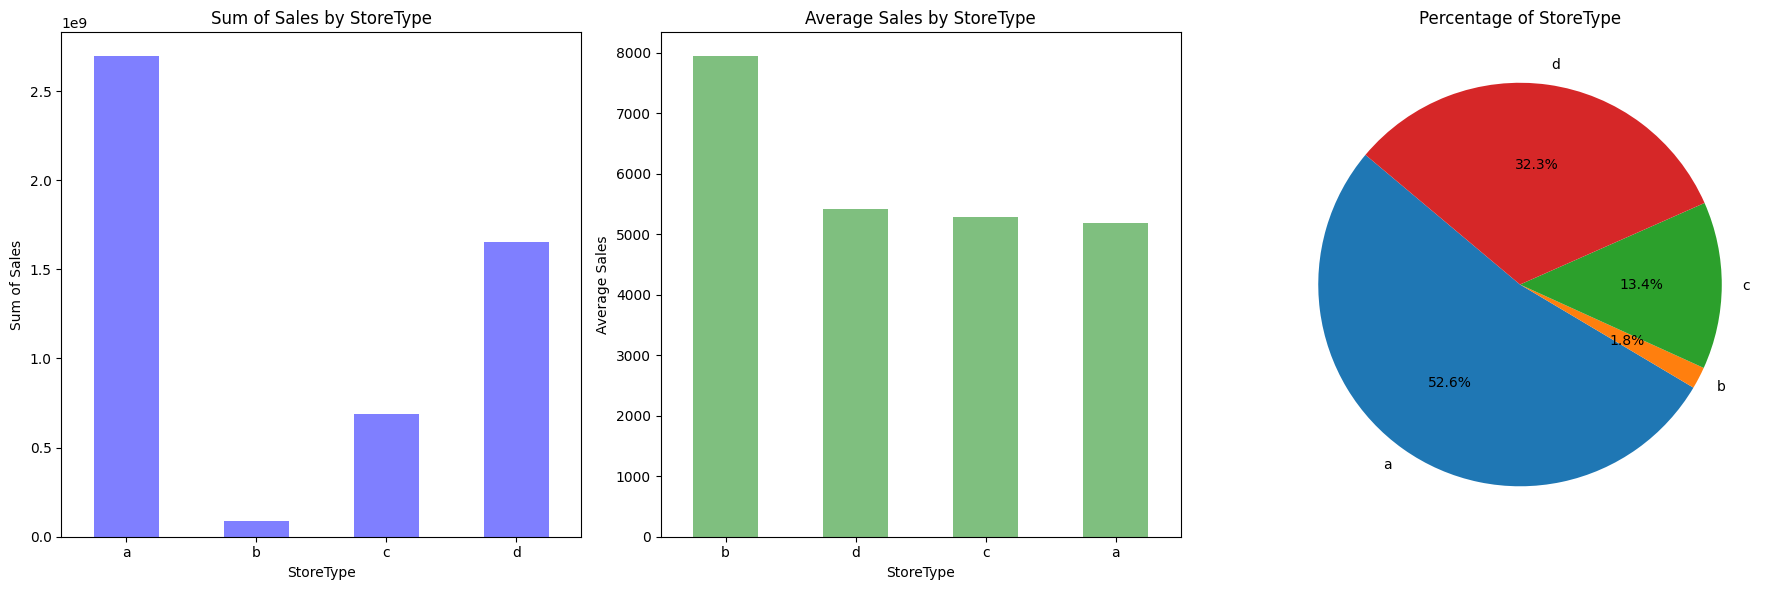

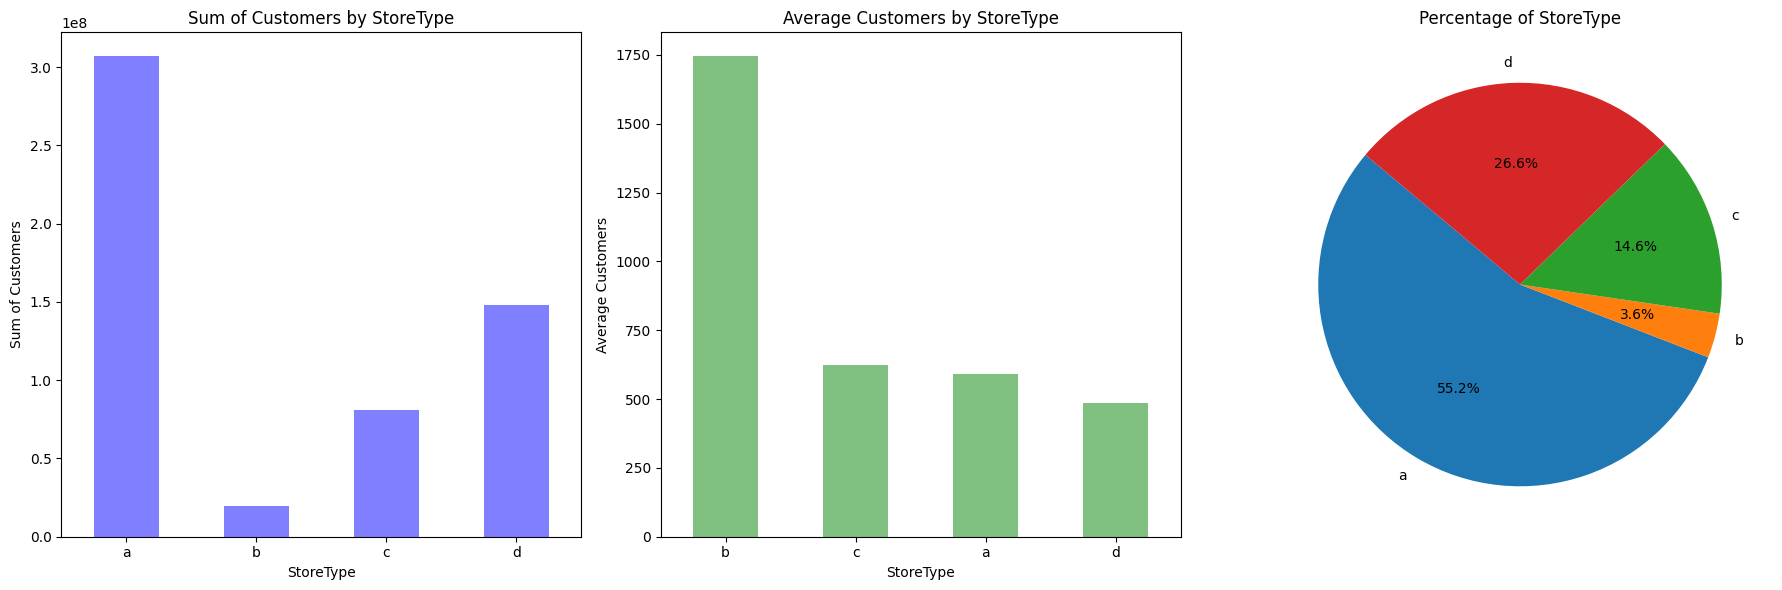

In [54]:
plot_sales_by_type_analysis(df_eda_rossman,'StoreType','Sales')
plot_sales_by_type_analysis(df_eda_rossman,'StoreType','Customers')


Dù tổnng số lượng bán hàng và số lượng khách hàng là thấp, nhưng loại cửa hàng b có doanh số bán hàng và số lượng khách hàng trung bình cao nhất. Điều này có nghĩa là khách hàng ưa thích loại cửa hàng b hơn.

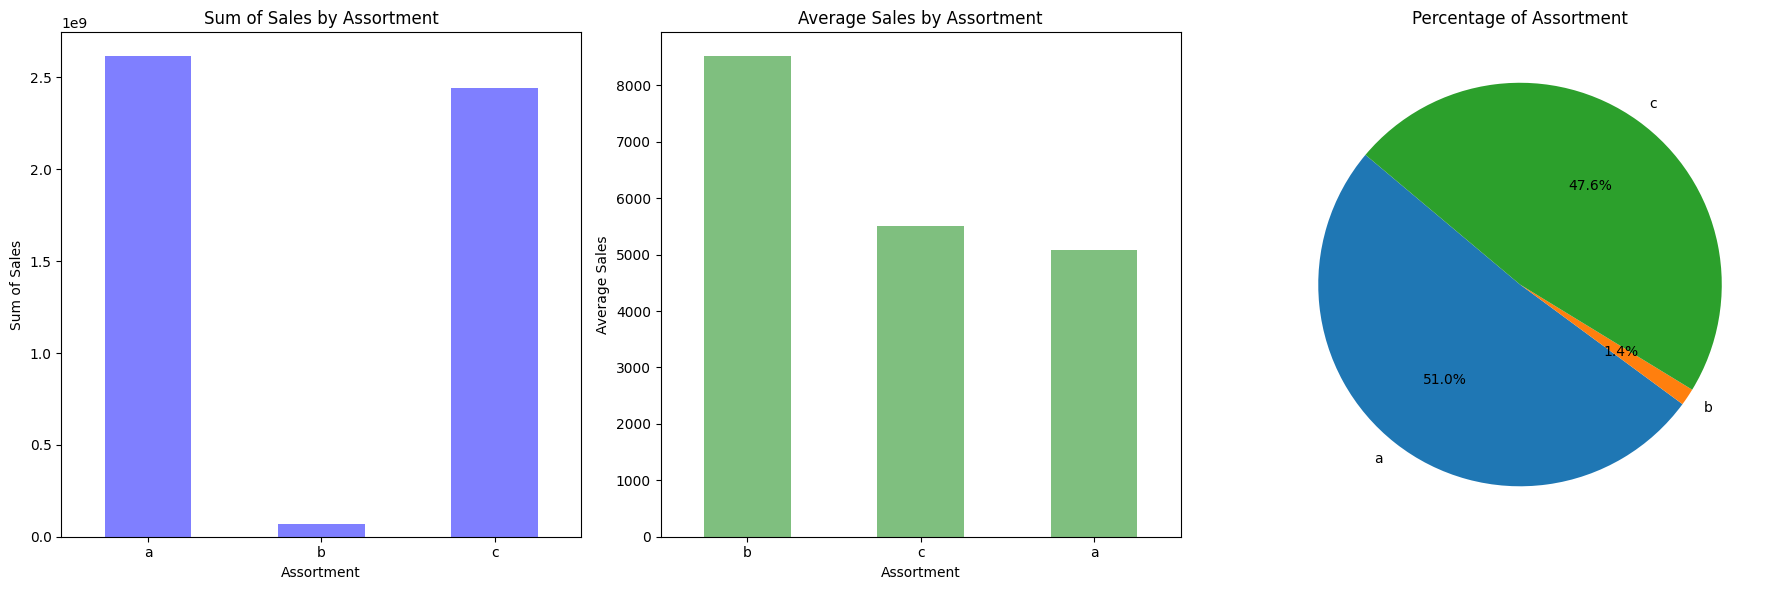

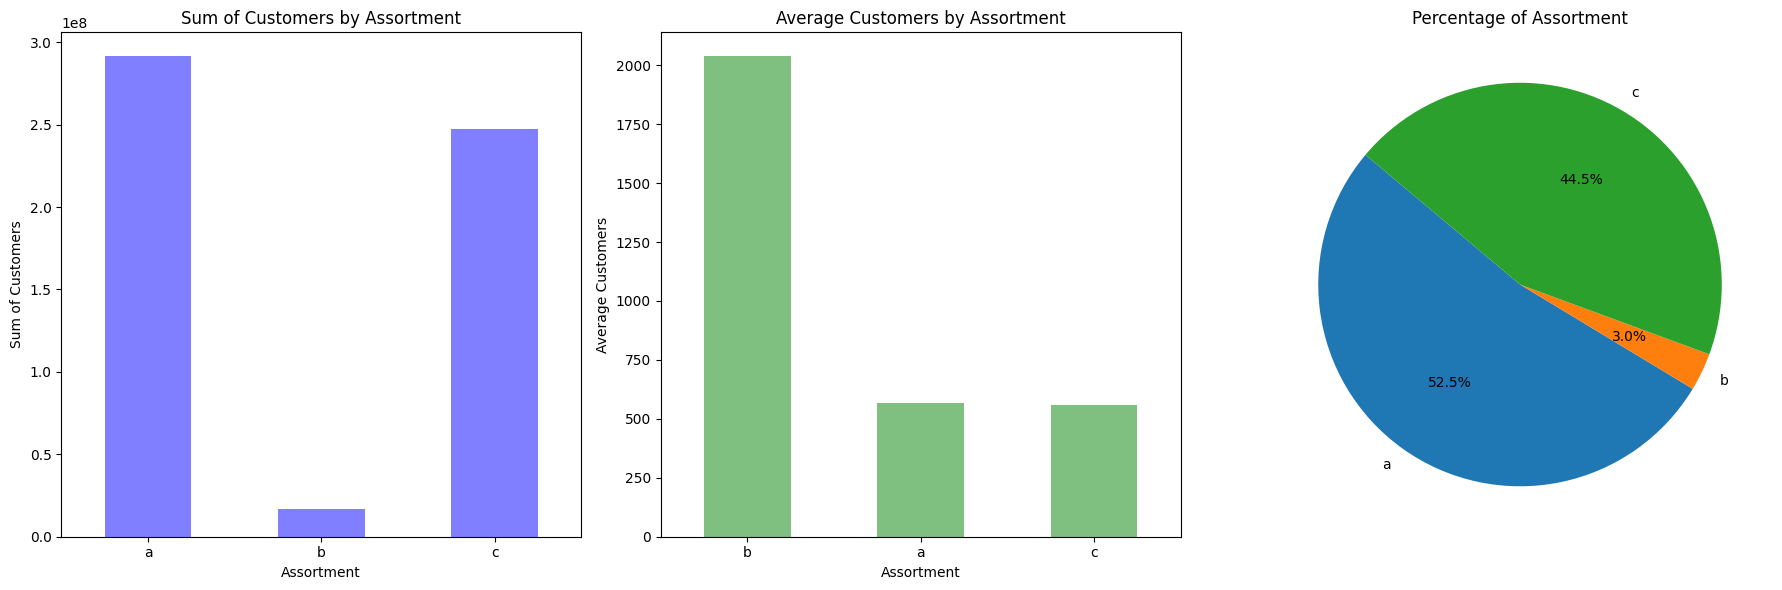

In [55]:
plot_sales_by_type_analysis(df_eda_rossman,'Assortment','Sales')
plot_sales_by_type_analysis(df_eda_rossman,'Assortment','Customers')



Dù khối lượng bán hàng và số lượng khách hàng là thấp, nhưng hàng hóa loại b có doanh số bán hàng và số lượng khách hàng trung bình cao nhất. Điều này có nghĩa là hợp đồng b đang có nhu cầu cao.

In [56]:
print(df_eda_rossman.head(10))

    Store  DayOfWeek       Date  Sales  Customers  Open  Promo  StateHoliday  \
0       1          5 2015-07-31   5263        555     1      1             0   
1       2          5 2015-07-31   6064        625     1      1             0   
2       3          5 2015-07-31   8314        821     1      1             0   
4       5          5 2015-07-31   4822        559     1      1             0   
5       6          5 2015-07-31   5651        589     1      1             0   
7       8          5 2015-07-31   8492        833     1      1             0   
8       9          5 2015-07-31   8565        687     1      1             0   
9      10          5 2015-07-31   7185        681     1      1             0   
10     11          5 2015-07-31  10457       1236     1      1             0   
11     12          5 2015-07-31   8959        962     1      1             0   

    SchoolHoliday StoreType  ... CompetitionOpenSinceYear  Promo2  \
0               1         c  ...                  

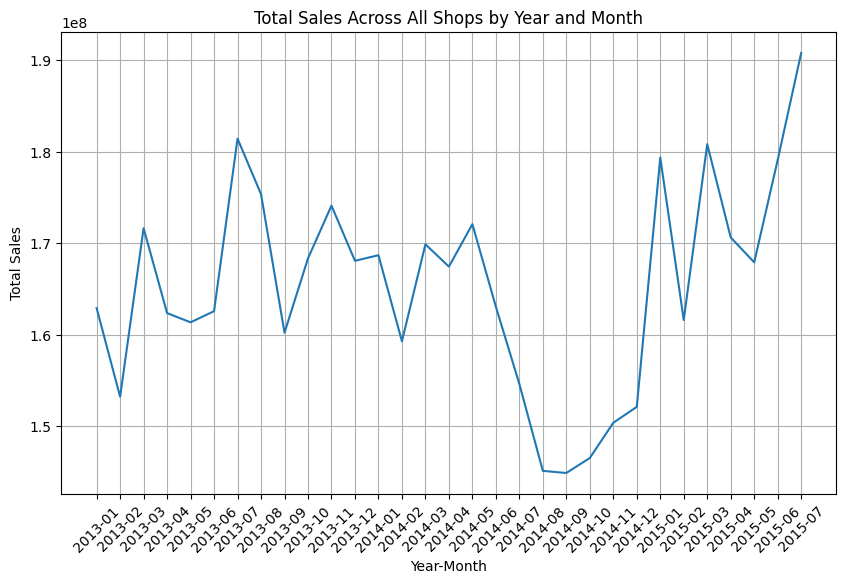

In [57]:
def plot_line_by_month(df):
    df['Date'] = pd.to_datetime(df['Date'])

    # Extract year and month from 'Date' column
    df['Year_Month'] = df['Date'].dt.to_period('M').astype(str)

    # Group by year and month and calculate total sales across all shops
    total_sales_by_year_month = df.groupby('Year_Month')['Sales'].sum().reset_index()

    # Plot the total sales across all shops by year and month
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Year_Month', y='Sales', data=total_sales_by_year_month)
    plt.title('Total Sales Across All Shops by Year and Month')
    plt.xlabel('Year-Month')
    plt.ylabel('Total Sales')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.grid(True)
    plt.show()

plot_line_by_month(df_eda_rossman)


Doanh số bán hàng dường như có tính chất mùa vụ, cao điểm là vào những tháng mùa xuân và mùa đông. Điều này có thể là do các yếu tố như ngày lễ, thời tiết và hoạt động mua sắm trong dịp tựu trường.

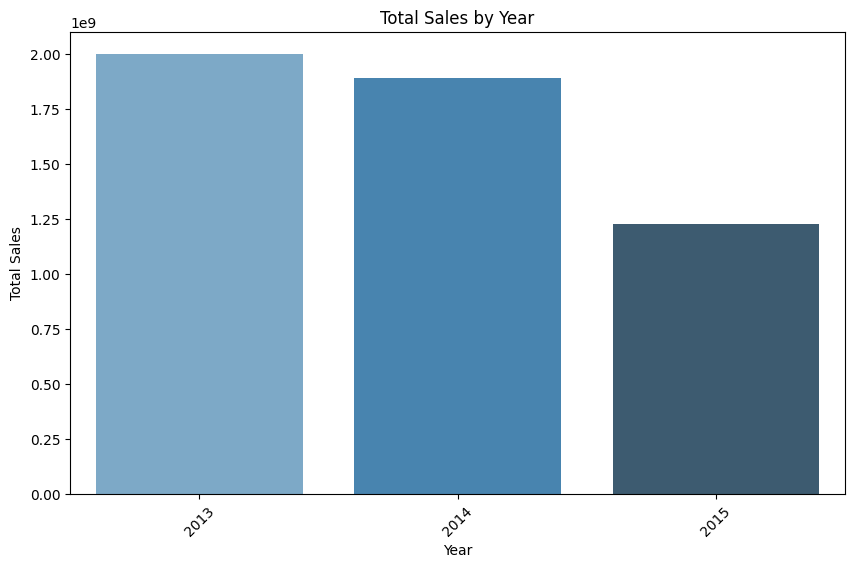

In [58]:
def plot_chart_by_year(df):
    df['Year'] = df['Date'].dt.year

    # Group by year and calculate total sales
    total_sales_by_year = df.groupby('Year')['Sales'].sum().reset_index()


    plt.figure(figsize=(10, 6))
    sns.barplot(x='Year', y='Sales', data=total_sales_by_year, palette='Blues_d')
    plt.title('Total Sales by Year')
    plt.xlabel('Year')
    plt.ylabel('Total Sales')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()
plot_chart_by_year(df_eda_rossman)

Hiệu suất bán hàng đã duy trì ổn định qua ba năm được xem xét (lưu ý: chúng ta chỉ có dữ liệu cho sáu tháng đầu tiên của năm 2015, điều này có nghĩa là tổng doanh số bán hàng cho năm 2015 chỉ là một nửa so với các năm trước, vì vậy chúng ta giả định rằng tổng doanh số bán hàng cho năm 2015 tương tự như năm 2014 và 2015). Biểu đồ cột cho thấy rằng tổng doanh số bán hàng tổng cộng trong mỗi năm (2013, 2014 và 2015) không có sự thay đổi đáng kể. Điều này cho thấy hiệu suất bán hàng của công ty đã duy trì ổn định trong khoảng thời gian này.

<Figure size 1600x800 with 0 Axes>

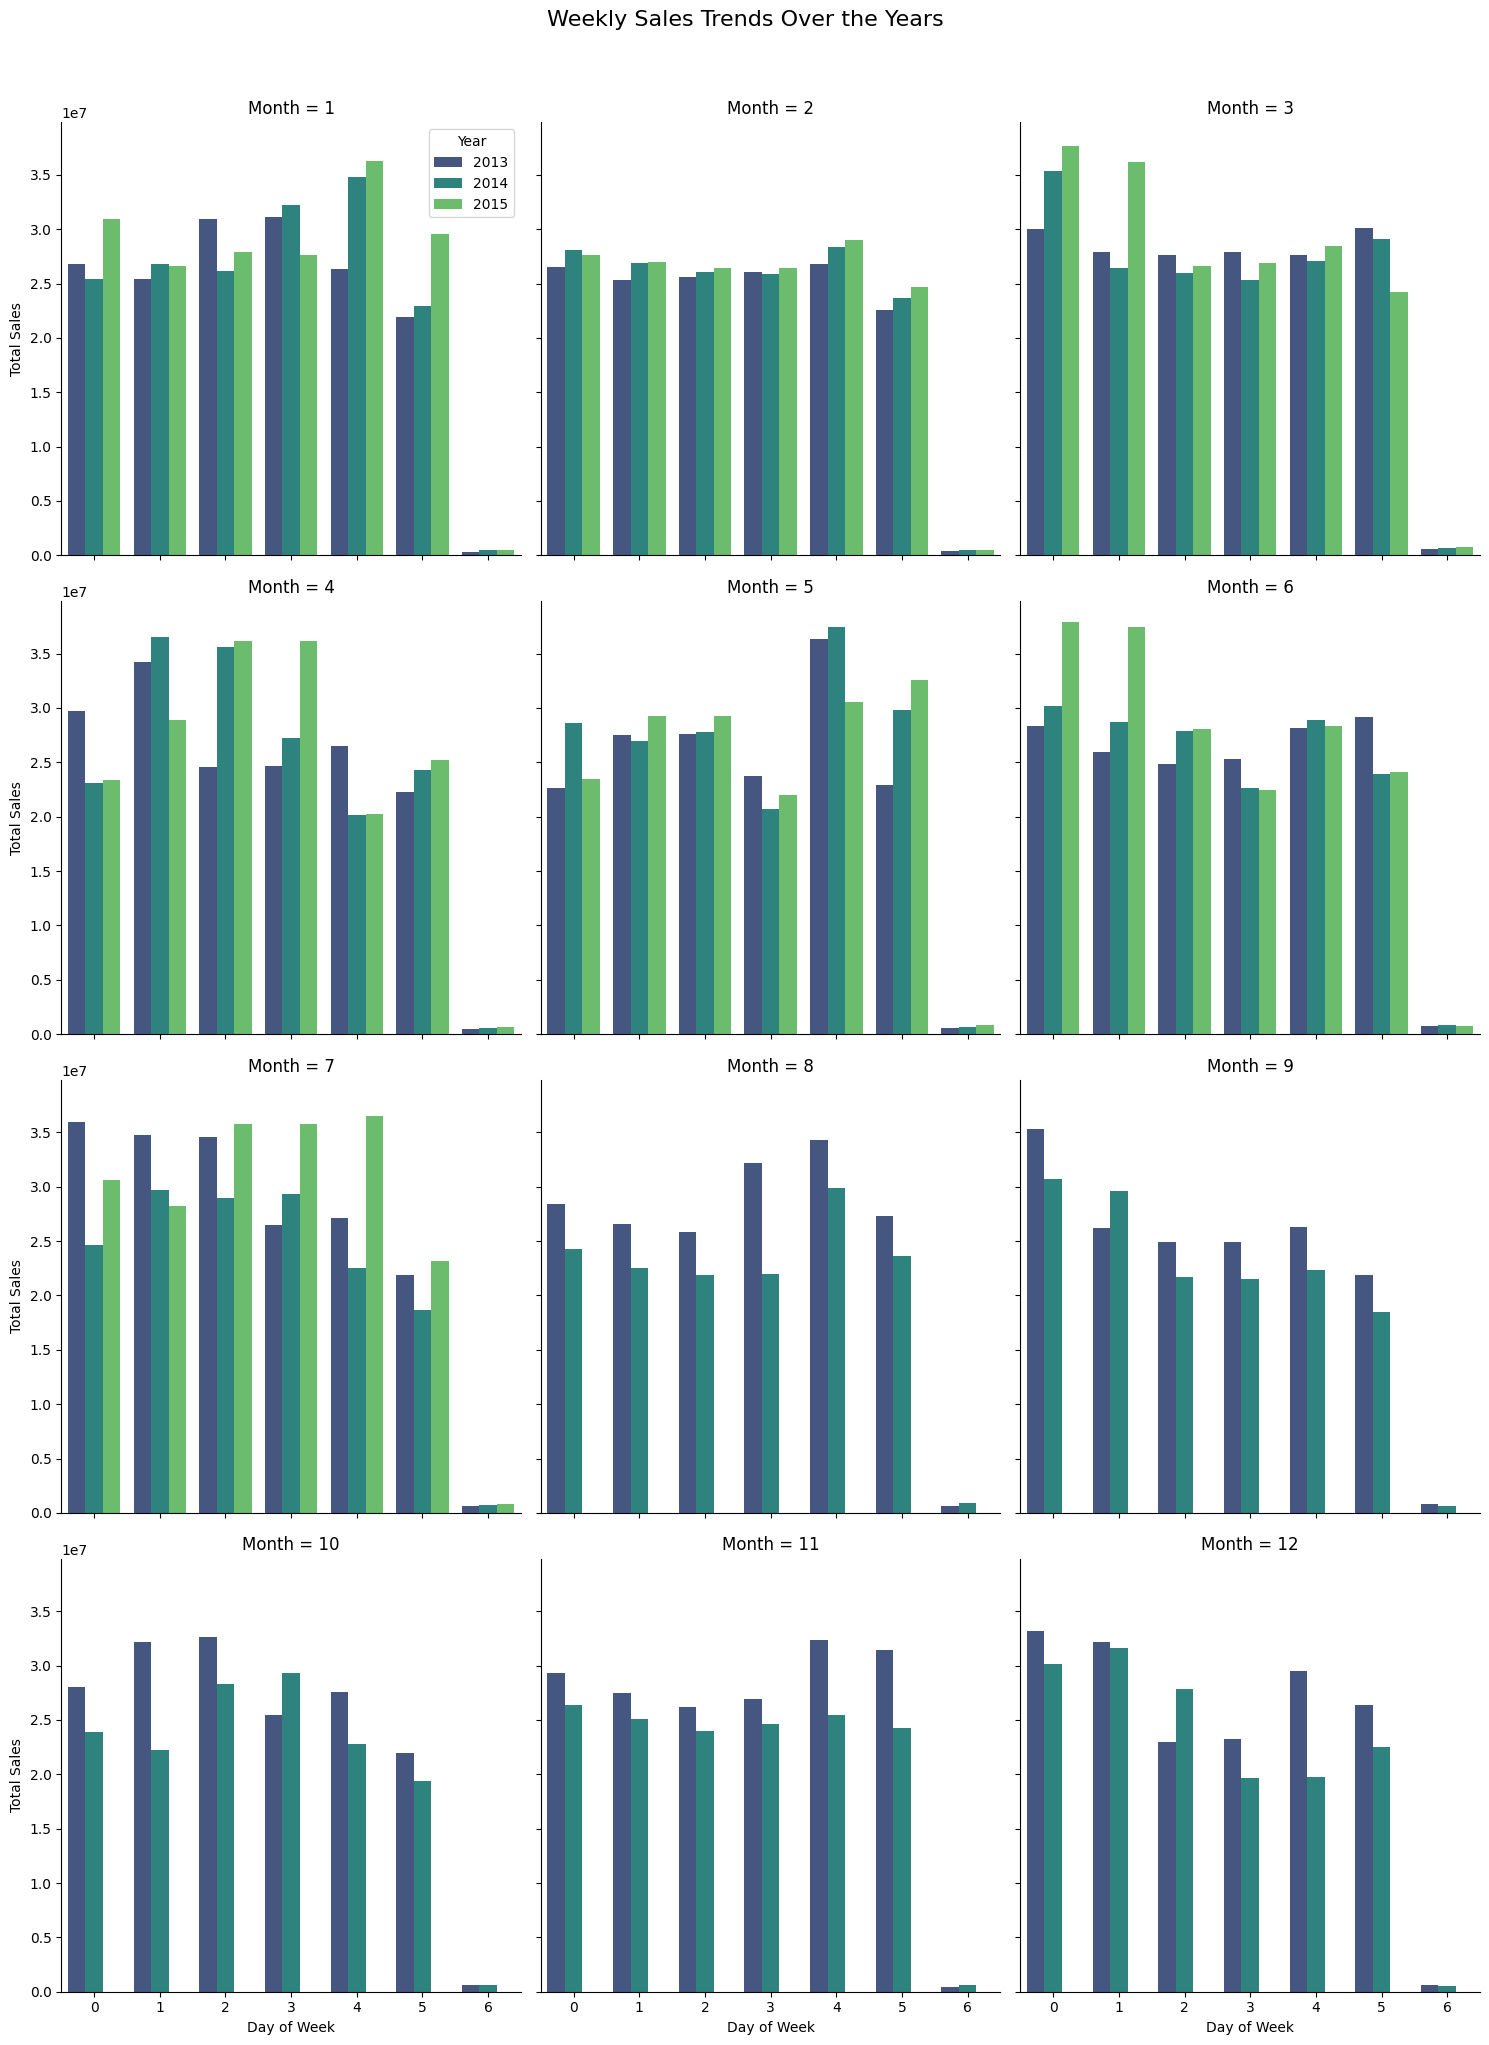

In [59]:
def plot_week_month_sales(df):
    # Convert 'Date' column to datetime type
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Extract month, year, and day of the week from the 'Date' column
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    
    # Group by day of the week, month, and year, then calculate total sales
    week_month_sales = df.groupby(['DayOfWeek', 'Month', 'Year'])['Sales'].sum().reset_index()
    
    # Plot the weekly sales trends over the years
    plt.figure(figsize=(16, 8))
    fig = sns.catplot(
        data=week_month_sales, kind="bar",
        x="DayOfWeek", y="Sales", hue="Year",
        col="Month", col_wrap=3,
        palette="viridis", legend_out=False
    )
    
    # Set labels and title
    fig.set_axis_labels("Day of Week", "Total Sales")
    fig.fig.suptitle("Weekly Sales Trends Over the Years", y=1.02, fontsize=16)

    # Set titles for each subplot
    for ax in fig.axes.flat:
        ax.set_title(f"{ax.get_title()}")

    plt.tight_layout()  # Ensure proper arrangement and spacing of facets
    plt.show()

plot_week_month_sales(df_eda_rossman)

- Doanh số bán hàng có xu hướng tương đối ổn định qua các ngày trong tuần.
- Có một mẫu doanh số hàng tuần rõ ràng, với các đỉnh thường xảy ra vào khoảng giữa tuần.
- Mỗi biểu đồ từng tháng cho thấy cách mẫu này lặp lại suốt cả năm, với sự biến động qua các tháng khác nhau.

## Data Preprocessing

### Handling Multicollinearity

Kiểm tra đa cộng tuyến đối với các numerical features ngoại trừ 'Sales' để loại bỏ các features có tương quan cao. Features có VIF lớn hơn 5 sẽ bị loại bỏ

In [60]:
numerical_independent_features = ['Customers', 'CompetitionDistance', 'CompetitionOpenNumMonths', 'Promo2NumWeeks']
temp_df = df_rossmann[numerical_independent_features]
vif_df = pd.DataFrame()
vif_df['Feature'] = numerical_independent_features
vif_df['VIF'] = [variance_inflation_factor(temp_df.values, i) for i in range(temp_df.shape[1])]
vif_df

,Feature,VIF
0,Customers,1.631847
1,CompetitionDistance,1.296697
2,CompetitionOpenNumMonths,1.355584
3,Promo2NumWeeks,1.286752


Các features đều có VIF nhỏ hơn 5.

### Feature Selection


In [61]:
df_rossmann.drop('Store', axis=1, inplace=True)
df_rossmann.drop('Date', axis=1, inplace=True)
df_rossmann.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear'], axis=1, inplace=True)
df_rossmann.drop(['Promo2', 'Promo2SinceWeek', 'Promo2SinceYear'], axis=1, inplace=True)
df_rossmann.drop('Month', axis=1, inplace=True)
df_rossmann.drop('Year', axis=1, inplace= True)
df_rossmann.head()

,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,PromoInterval,WeekOfYear,CompetitionOpenNumMonths,Promo2NumWeeks
0,5,5263,555,1,1,0,1,c,a,1270.0,0,31,82,0
1,5,6064,625,1,1,0,1,a,a,570.0,"Jan,Apr,Jul,Oct",31,92,278
2,5,8314,821,1,1,0,1,a,a,14130.0,"Jan,Apr,Jul,Oct",31,103,225
4,5,4822,559,1,1,0,1,a,a,29910.0,0,31,3,0
5,5,5651,589,1,1,0,1,a,a,310.0,0,31,19,0


### Feature Transformation

Việc chuyển đổi các numerical features rất quan trọng vì các thuật toán như hồi quy tuyến tính, giả định phân phối chuẩn, hoạt động tốt hơn khi các đối tượng gần với phân phối chuẩn.

Kiểm tra phân phối của các numerical features.

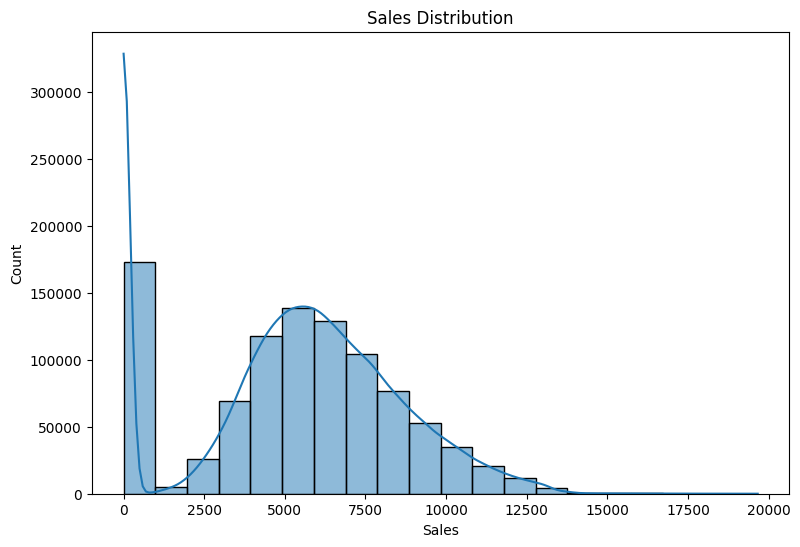

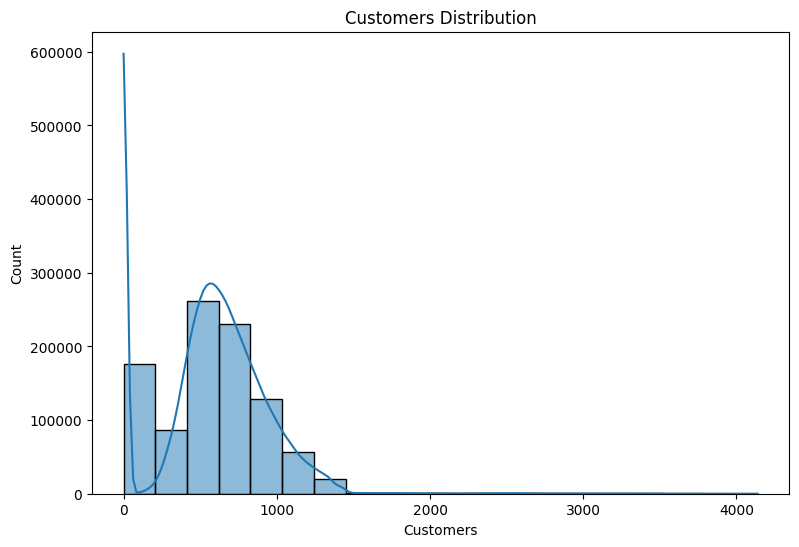

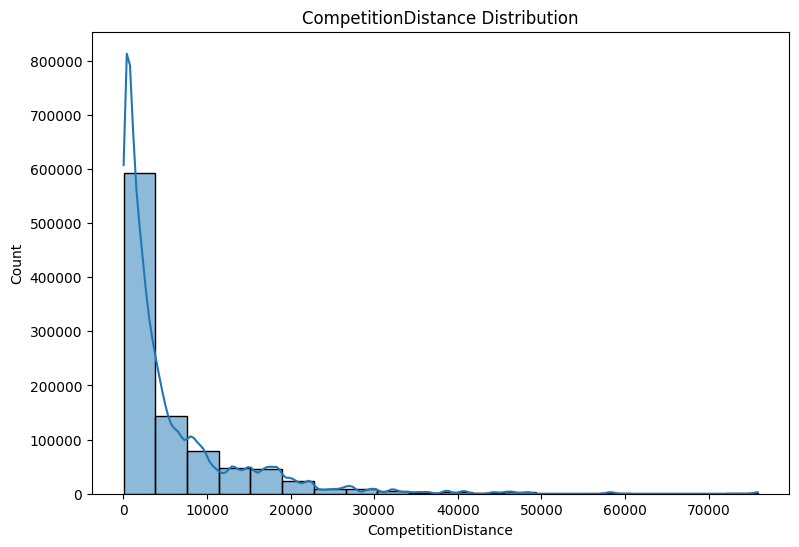

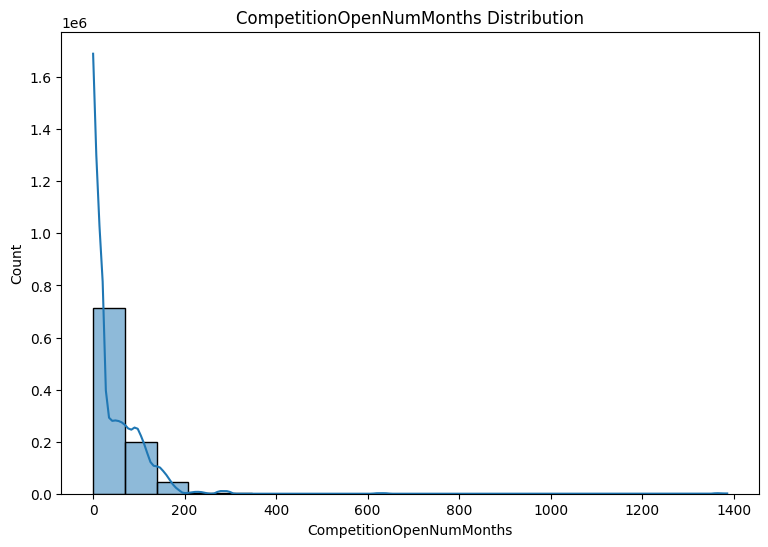

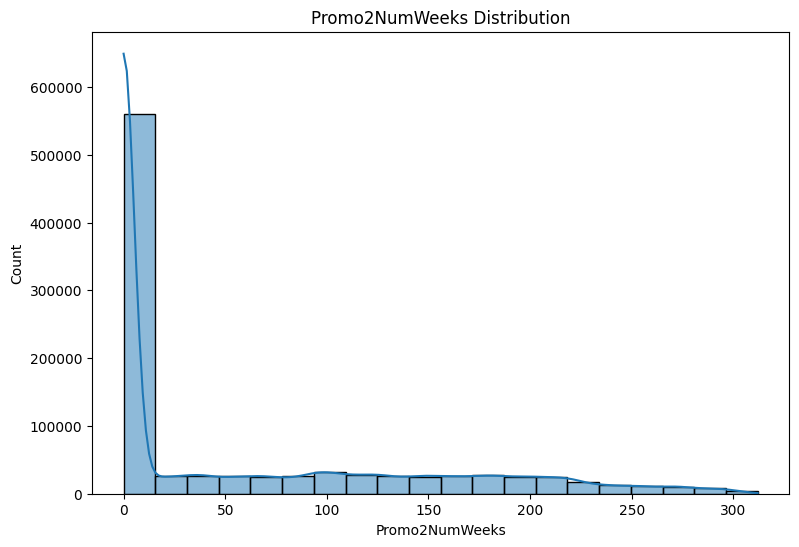

In [62]:

numerical_features = ['Sales', 'Customers', 'CompetitionDistance', 'CompetitionOpenNumMonths', 'Promo2NumWeeks']

for feature in numerical_features:
    plt.figure(figsize=(9, 6))  
    sns.histplot(df_rossmann[feature], kde=True, bins=20, fill=True) 
    plt.title(f'{feature} Distribution')  
    plt.show()  

Tất cả các feature đều lệch dương, do đó các features cần được transform thành phân phối chuẩn

In [63]:
for feature in numerical_features:
    min_value = df_rossmann[feature].min()
    max_value = df_rossmann[feature].max()
    print(f'{feature}: Min={min_value}, Max={max_value}')

Sales: Min=0, Max=19662
Customers: Min=0, Max=4139
CompetitionDistance: Min=20.0, Max=75860.0
CompetitionOpenNumMonths: Min=0, Max=1386
Promo2NumWeeks: Min=0, Max=312


Sales, Customers, CompetitionOpenNumMonths và Promo2NumWeeks đều có các giá trị lớn hơn hoặc bằng 0, các features này sẽ được sử dụng square root transform. CompetitionDistance có các giá trị đều lớn hơn 0, features này sẽ được sử dụng log transform

In [64]:
df_rossmann['Sales'] = np.sqrt(df_rossmann['Sales'])
df_rossmann['Customers'] = np.sqrt(df_rossmann['Customers'])
df_rossmann['CompetitionOpenNumMonths'] = np.sqrt(df_rossmann['CompetitionOpenNumMonths'])
df_rossmann['Promo2NumWeeks'] = np.sqrt(df_rossmann['Promo2NumWeeks'])

df_rossmann['CompetitionDistance'] = np.log(df_rossmann['CompetitionDistance'])

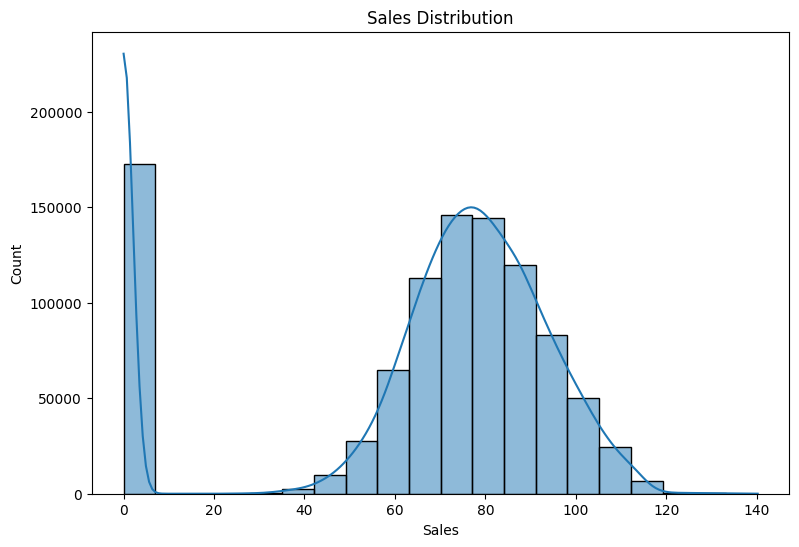

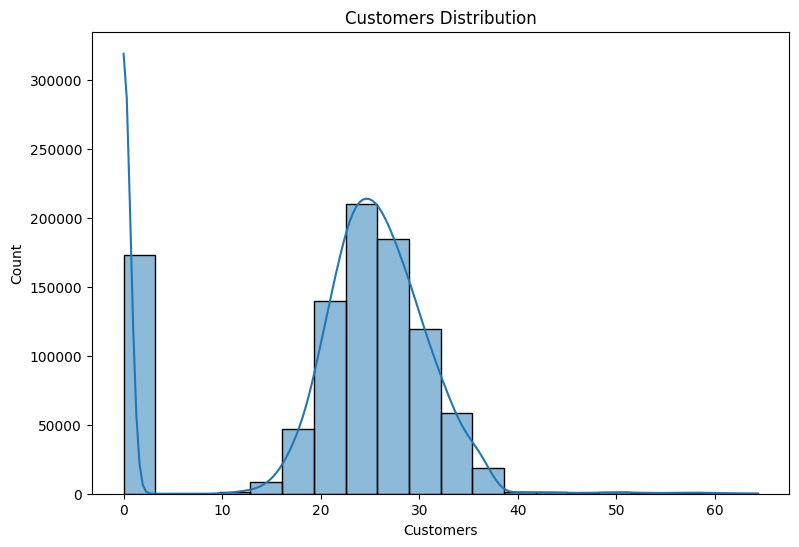

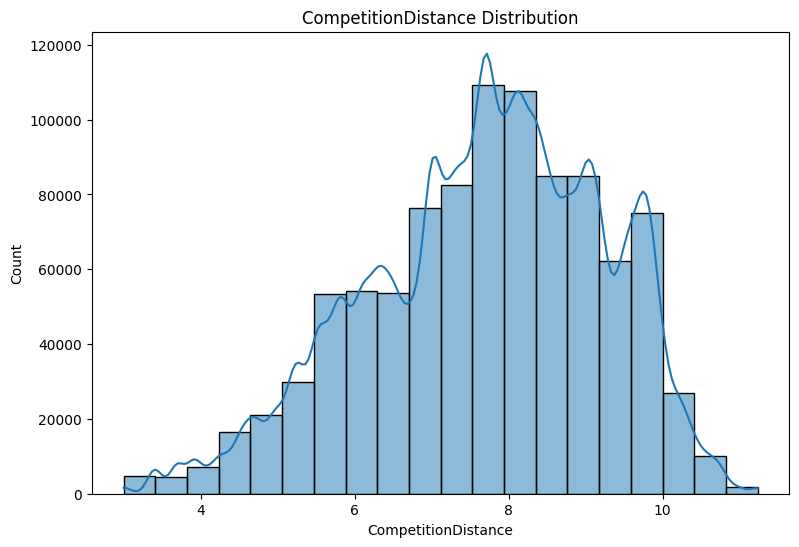

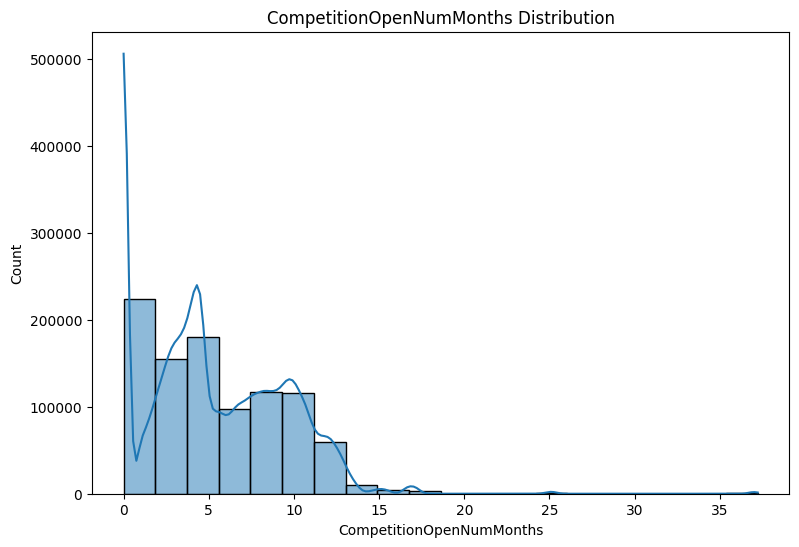

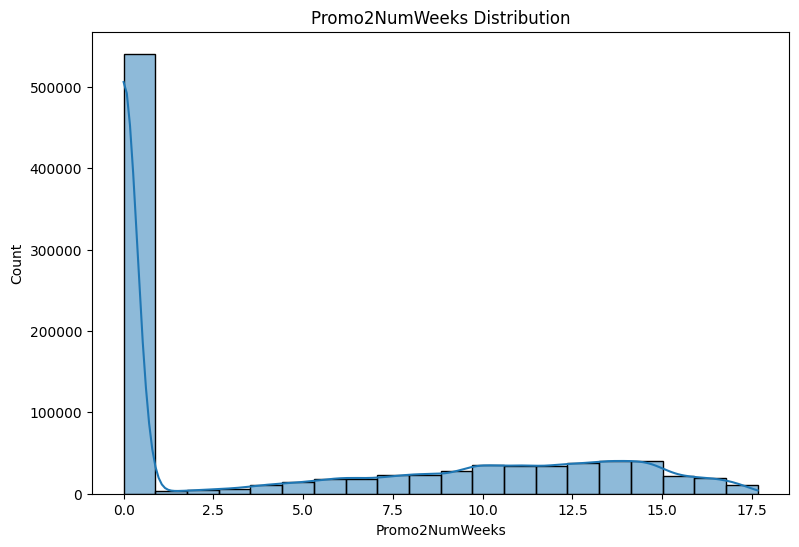

In [65]:
numerical_features = ['Sales', 'Customers', 'CompetitionDistance', 'CompetitionOpenNumMonths', 'Promo2NumWeeks']

for feature in numerical_features:
    plt.figure(figsize=(9, 6))  
    sns.histplot(df_rossmann[feature], kde=True, bins=20, fill=True) 
    plt.title(f'{feature} Distribution')  
    plt.show() 

#### Encoding

In [66]:
bin = ce.BinaryEncoder(cols=['DayOfWeek']).fit_transform(df_rossmann['DayOfWeek'])
df_rossmann = pd.concat([df_rossmann, bin], axis=1)
df_rossmann.drop('DayOfWeek', axis=1, inplace=True)

bin = ce.BinaryEncoder(cols=['WeekOfYear']).fit_transform(df_rossmann['WeekOfYear'])
df_rossmann = pd.concat([df_rossmann, bin], axis=1)
df_rossmann.drop('WeekOfYear', axis=1, inplace=True)

In [67]:
cat_col = ['StoreType', 'Assortment']
data_cat = df_rossmann[cat_col].copy()

data_cat = pd.get_dummies(data_cat,columns=cat_col)
data_cat = data_cat.astype(int)

df_rossmann = pd.concat([df_rossmann, data_cat],axis=1)
df_rossmann.drop(columns=cat_col,inplace=True)


In [68]:
df_rossmann = pd.get_dummies(df_rossmann, columns=['PromoInterval'])

##### Correlation between new features after encoding

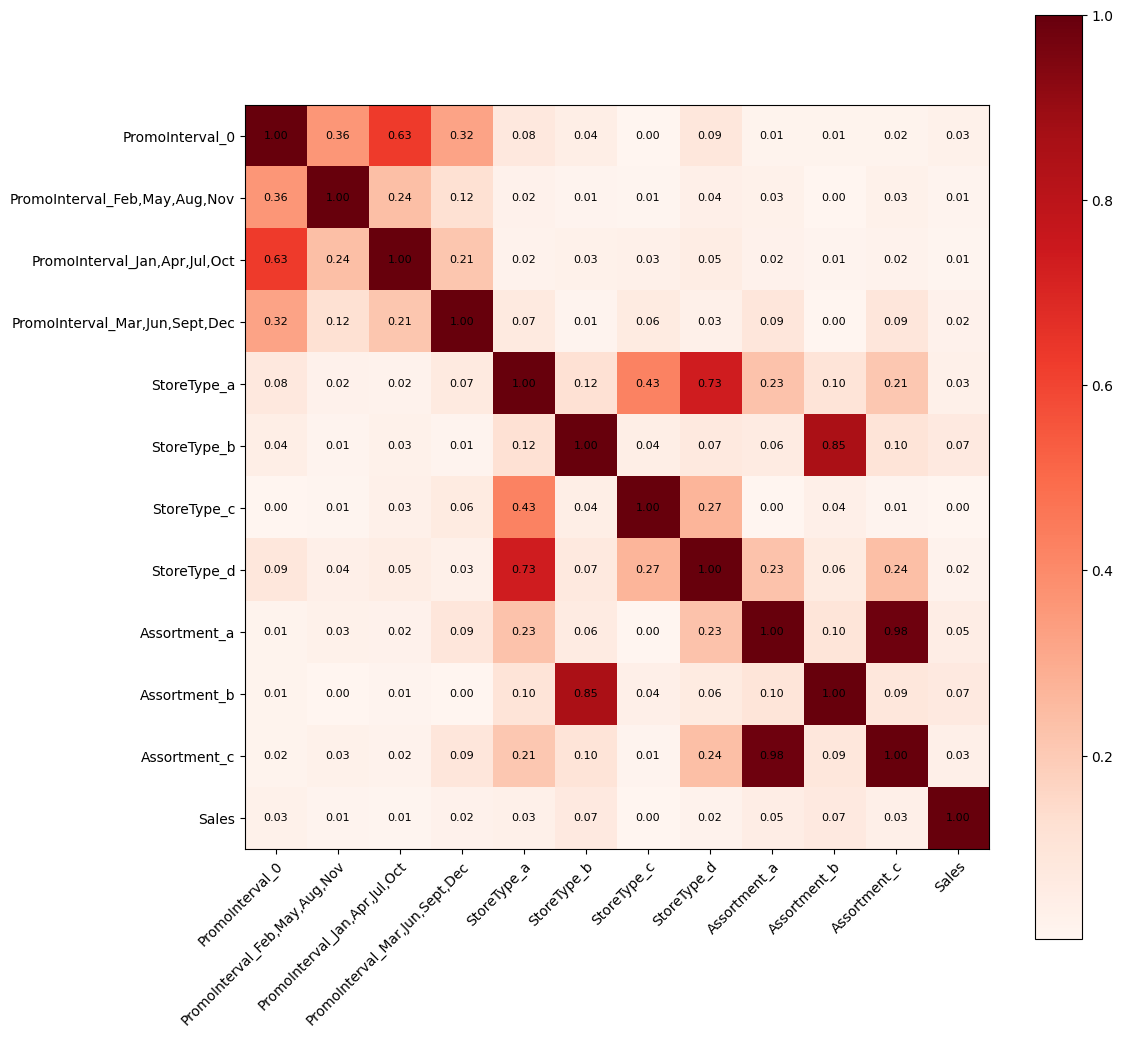

In [69]:
corr = df_rossmann.loc[:, ['PromoInterval_0', 'PromoInterval_Feb,May,Aug,Nov', 'PromoInterval_Jan,Apr,Jul,Oct', 'PromoInterval_Mar,Jun,Sept,Dec', 
                           'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c', 'Sales']].corr().abs()

fig, ax = plt.subplots(figsize=(12, 12))

cax = ax.imshow(corr, interpolation='nearest', cmap='Reds')
fig.colorbar(cax)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(corr.columns)), labels=corr.columns)
ax.set_yticks(np.arange(len(corr.index)), labels=corr.index)

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations with a smaller font size.
for i in range(len(corr.index)):
    for j in range(len(corr.columns)):
        ax.text(j, i, '{:.2f}'.format(corr.iloc[i, j]), ha='center', va='center', 
                color='black', fontsize=8)  # Adjust the fontsize here

plt.show()

PromoInterval_Jan,Apr,Jul,Oct, StoreType_c và PromoInterval_Feb,May,Aug,Nov có tương quan yếu nhất với Sales. Các feature này sẽ bị loại.

In [70]:
df_rossmann.drop(['PromoInterval_Jan,Apr,Jul,Oct', 'StoreType_c', 'PromoInterval_Feb,May,Aug,Nov'], axis=1, inplace=True)

#### Standardlization

In [71]:
cols=df_rossmann.columns.tolist()
cols.remove("Sales")
cols.remove("Customers")
cols.remove("Promo")
cols
scaler = StandardScaler()
df_rossmann[cols]=scaler.fit_transform(df_rossmann[cols])
df_rossmann.head()

,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,CompetitionOpenNumMonths,Promo2NumWeeks,DayOfWeek_0,...,WeekOfYear_4,WeekOfYear_5,StoreType_a,StoreType_b,StoreType_d,Assortment_a,Assortment_b,Assortment_c,PromoInterval_0,"PromoInterval_Mar,Jun,Sept,Dec"
0,72.546537,23.558438,0.466718,1,-0.181839,2.161874,-0.357367,0.920431,-0.805967,-1.148131,...,-1.011889,0.998284,-1.078859,-0.108983,-0.67947,0.937454,-0.092859,-0.921477,1.023108,-0.330857
1,77.871689,25.000000,0.466718,1,-0.181839,2.161874,-0.879534,1.051394,2.006798,-1.148131,...,-1.011889,0.998284,0.926905,-0.108983,-0.67947,0.937454,-0.092859,-0.921477,-0.977414,-0.330857
2,91.181138,28.653098,0.466718,1,-0.181839,2.161874,1.212965,1.187474,1.724509,-1.148131,...,-1.011889,0.998284,0.926905,-0.108983,-0.67947,0.937454,-0.092859,-0.921477,-0.977414,-0.330857
4,69.440622,23.643181,0.466718,1,-0.181839,2.161874,1.701733,-0.867985,-0.805967,-1.148131,...,-1.011889,0.998284,0.926905,-0.108983,-0.67947,0.937454,-0.092859,-0.921477,1.023108,-0.330857
5,75.173133,24.269322,0.466718,1,-0.181839,2.161874,-1.276512,-0.226488,-0.805967,-1.148131,...,-1.011889,0.998284,0.926905,-0.108983,-0.67947,0.937454,-0.092859,-0.921477,1.023108,-0.330857


## Modeling

In [72]:
def calculate_rmspe(y_actual, y_pred):
    """Calculate Root Mean Square Percentage Error."""
    y_actual, y_pred = np.array(y_actual), np.array(y_pred)
    return np.sqrt(np.mean(np.square((y_actual - y_pred) / y_actual))) * 100

def calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred):
    """Calculate and return model performance metrics."""
    metrics_dict = {
        'Train_R2': r2_score(y_train, y_train_pred),
        'Test_R2': r2_score(y_test, y_test_pred),
        'Train_RMSE': mean_squared_error(y_train, y_train_pred, squared=False),
        'Test_RMSE': mean_squared_error(y_test, y_test_pred, squared=False),
        'Train_RMSPE': calculate_rmspe(y_train, y_train_pred),
        'Test_RMSPE': calculate_rmspe(y_test, y_test_pred),
        'Train_MAE': mean_absolute_error(y_train, y_train_pred),
        'Test_MAE': mean_absolute_error(y_test, y_test_pred),
        'Train_MAPE': np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100,
        'Test_MAPE': np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
    }
    return metrics_dict

### Train-Test Split

In [73]:
X = df_rossmann.drop(['Sales', 'Customers', 'Promo'], axis=1)
y = df_rossmann['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)

In [74]:
metrics_table = pd.DataFrame(columns=['Regression_Model', 'Train_R2', 'Test_R2', 'Train_RMSE', 'Test_RMSE', 'Train_RMSPE', 'Test_RMSPE'])

In [75]:
linear_reg = LinearRegression()
liner_reg_model = Pipeline([('linear_reg', linear_reg)])
liner_reg_model.fit(X_train, y_train)
y_train_pred = liner_reg_model.predict(X_train)
y_test_pred = liner_reg_model.predict(X_test)


In [76]:
model_evaluation = calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred)


print(f"Training Data\nR2    : {model_evaluation['Train_R2']}\nRMSE  : {model_evaluation['Train_RMSE']}\nRMSPE : {model_evaluation['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")


metrics_table.loc[len(metrics_table.index)] = ['Linear', model_evaluation['Train_R2'], model_evaluation['Test_R2'], 
                                                         model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'], 
                                                         model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE']]


Training Data
R2    : 0.8527408007327179
RMSE  : 12.669381224149154
RMSPE : inf%

Testing Data
R2    : 0.8530286479776478
RMSE  : 12.665895503957525
RMSPE : inf%


In [77]:
ridge_regression = Ridge()
ridge_regression_model = Pipeline([( 'ridge', ridge_regression)])
ridge_regression_model.fit(X_train, y_train)
y_train_pred = ridge_regression_model.predict(X_train)
y_test_pred = ridge_regression_model.predict(X_test)

In [78]:
model_evaluation = calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred)


print(f"Training Data\nR2    : {model_evaluation['Train_R2']}\nRMSE  : {model_evaluation['Train_RMSE']}\nRMSPE : {model_evaluation['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")

metrics_table.loc[len(metrics_table.index)] = ['Decision_Tree', model_evaluation['Train_R2'], model_evaluation['Test_R2'], 
                                                         model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'], 
                                                         model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE']]


Training Data
R2    : 0.8527408007180177
RMSE  : 12.669381224781512
RMSPE : inf%

Testing Data
R2    : 0.8530286471517738
RMSE  : 12.665895539544167
RMSPE : inf%


In [79]:
lasso_regression = Lasso()
lasso_regression_model = Pipeline([( 'lasso', lasso_regression )])
lasso_regression_model.fit(X_train, y_train)
y_train_pred = lasso_regression_model.predict(X_train)
y_test_pred = lasso_regression_model.predict(X_test)

In [80]:
model_evaluation = calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred)


print(f"Training Data\nR2    : {model_evaluation['Train_R2']}\nRMSE  : {model_evaluation['Train_RMSE']}\nRMSPE : {model_evaluation['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")

metrics_table.loc[len(metrics_table.index)] = ['Decision_Tree', model_evaluation['Train_R2'], model_evaluation['Test_R2'], 
                                                         model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'], 
                                                         model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE']]

Training Data
R2    : 0.8460183025719878
RMSE  : 12.955337712786243
RMSPE : inf%

Testing Data
R2    : 0.8461473513171931
RMSE  : 12.959016555219515
RMSPE : inf%


In [81]:
knn = KNeighborsRegressor(n_neighbors = 1,weights = 'uniform')
knn_model = Pipeline([('k-neighbor', knn)])
knn_model.fit(X_train,y_train)
y_train_pred = knn_model.predict(X_train)
y_test_pred = knn_model.predict(X_test)

In [82]:
model_evaluation = calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred)


print(f"Training Data\nR2    : {model_evaluation['Train_R2']}\nRMSE  : {model_evaluation['Train_RMSE']}\nRMSPE : {model_evaluation['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")

metrics_table.loc[len(metrics_table.index)] = ['K-Neighbor', model_evaluation['Train_R2'], model_evaluation['Test_R2'], 
                                                         model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'], 
                                                         model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE']]

Training Data
R2    : 0.9985000864862378
RMSE  : 1.2786370840332166
RMSPE : nan%

Testing Data
R2    : 0.8143621270800117
RMSE  : 14.23484844822467
RMSPE : nan%


In [83]:
random_forest = RandomForestRegressor()
random_forest_model = Pipeline([ ('random_forest', random_forest)])
random_forest_model.fit(X_train, y_train)
y_train_pred = random_forest_model.predict(X_train)
y_test_pred = random_forest_model.predict(X_test)

In [84]:
model_evaluation = calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred)


print(f"Training Data\nR2    : {model_evaluation['Train_R2']}\nRMSE  : {model_evaluation['Train_RMSE']}\nRMSPE : {model_evaluation['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")

metrics_table.loc[len(metrics_table.index)] = ['Random_Forest', model_evaluation['Train_R2'], model_evaluation['Test_R2'], 
                                                         model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'], 
                                                         model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE']]


Training Data
R2    : 0.9940084849104434
RMSE  : 2.555539015540367
RMSPE : nan%

Testing Data
R2    : 0.9610410621737584
RMSE  : 6.521133781923775
RMSPE : nan%


In [85]:
xgboost = xgb.XGBRegressor()
xgboost_model = Pipeline([('xgboost', xgboost)])
xgboost_model.fit(X_train, y_train)
y_train_pred = xgboost_model.predict(X_train)
y_test_pred = xgboost_model.predict(X_test)

In [86]:
model_evaluation = calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred)


print(f"Training Data\nR2    : {model_evaluation['Train_R2']}\nRMSE  : {model_evaluation['Train_RMSE']}\nRMSPE : {model_evaluation['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")

metrics_table.loc[len(metrics_table.index)] = ['XG_Boost', model_evaluation['Train_R2'], model_evaluation['Test_R2'], 
                                                         model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'], 
                                                         model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE']]

Training Data
R2    : 0.9444477087489382
RMSE  : 7.781533206478083
RMSPE : inf%

Testing Data
R2    : 0.9442146452852456
RMSE  : 7.803324286357753
RMSPE : inf%


Improve with Hyperparameter

In [87]:
random_forest = RandomForestRegressor()
parameters = {'max_depth': [5, 10, None],
              'min_samples_leaf': [1, 2, 5],
              'min_samples_split': [2, 5, 10],
              'max_leaf_nodes': [5, 20, 100],
              'max_features': ['auto', 'sqrt', 'log2']}

# RandomizedSearchCV is used for hyperparameter tuning because RandomForestRegressor() have multiple hyperparameters
# cv=3 & n_iter=10 since dataset is large
rf_reg = RandomizedSearchCV(estimator=random_forest, param_distributions=parameters, n_iter=10, cv=3)
rf_reg.fit(X_train, y_train)

# print the best parameter values and negative mean squared error
print("The best parameters for random forest regression: ")
for key, value in rf_reg.best_params_.items():
  print(f"{key}={value}")
print(f"\nNegative mean squared error: {rf_reg.best_score_}")

# predict the train and test data
y_train_pred = rf_reg.predict(X_train)
y_test_pred = rf_reg.predict(X_test)

The best parameters for random forest regression: 
min_samples_split=5
min_samples_leaf=5
max_leaf_nodes=100
max_features=sqrt
max_depth=10

Negative mean squared error: 0.8621173650794801


In [88]:
model_evaluation = calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred)

# print the results of model evaluation
print(f"Training Data\nR2    : {model_evaluation['Train_R2']}\nRMSE  : {model_evaluation['Train_RMSE']}\nRMSPE : {model_evaluation['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")
# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['Random Forest', model_evaluation['Train_R2'], model_evaluation['Test_R2'], 
                                                         model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'], 
                                                         model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE']]

Training Data
R2    : 0.8617748454143642
RMSE  : 12.274610762101338
RMSPE : inf%

Testing Data
R2    : 0.8618188630455863
RMSE  : 12.281288595410171
RMSPE : inf%


In [89]:
# train data with XGBoost regression
xgboost = xgb.XGBRegressor(objective='reg:linear', verbosity=0)
parameters = {'max_depth': [2, 5, 3],
              'learning_rate': [0.05, 0.1, 0.2],
              'min_child_weight': [1, 2, 5],
              'gamma': [0, 0.1, 0.3],
              'colsample_bytree': [0.3, 0.5, 0.7]}

# RandomizedSearchCV is used for hyperparameter tuning because XGBRegressor() have multiple hyperparameters
# cv=3 & n_iter=10 since dataset is large
xg_reg = RandomizedSearchCV(estimator=xgboost, param_distributions=parameters, n_iter=10, cv=3)
xg_reg.fit(X_train, y_train)

print("The best parameters for XGBoost regression: ")
for key, value in xg_reg.best_params_.items():
  print(f"{key}={value}")
print(f"\nNegative mean squared error: {xg_reg.best_score_}")


y_train_pred = xg_reg.predict(X_train)
y_test_pred = xg_reg.predict(X_test)

The best parameters for XGBoost regression: 
min_child_weight=5
max_depth=3
learning_rate=0.2
gamma=0.3
colsample_bytree=0.5

Negative mean squared error: 0.8781129422628928


In [90]:
model_evaluation = calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred)


print(f"Training Data\nR2    : {model_evaluation['Train_R2']}\nRMSE  : {model_evaluation['Train_RMSE']}\nRMSPE : {model_evaluation['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")
metrics_table.loc[len(metrics_table.index)] = ['XGBoost',  model_evaluation['Train_R2'], model_evaluation['Test_R2'], 
                                                         model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'], 
                                                         model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE']]

Training Data
R2    : 0.877554184297535
RMSE  : 11.552770909095377
RMSPE : inf%

Testing Data
R2    : 0.8776857315605284
RMSE  : 11.554685178272653
RMSPE : inf%
